In [1]:
!pip install openml
!pip install -U albumentations
!pip install optuna-integration[tfkeras]
!pip install visualkeras

  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 6.0 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=45a3d8293d76fa9cdc11be031970d274df7811856ff6863780d32b924d0941a1
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 13.2 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import random
import json
import os
import gc

import optuna
from optuna.integration import TFKerasPruningCallback
import openml as oml
from collections import Counter
import cv2  

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_auc_score, 
                             average_precision_score, precision_recall_curve, auc)

# Albumentations pour l'augmentation d'images
import albumentations as A

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, callbacks
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     BatchNormalization, Add, ReLU, GlobalAveragePooling2D, 
                                     UpSampling2D)
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.applications import ResNet50

from keras.utils import plot_model
import visualkeras

from IPython.display import clear_output

# projet-sda-deep-learning
#### [GTSRB - German Traffic Sign Recognition Benchmark](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign)

## 1. **Introduction au Projet**
  Le projet consiste en une classification de panneaux de signalisation routière, avec l'objectif de développer un modèle de reconnaissance d'images capable de distinguer différentes classes de panneaux de signalisation.  
  Le projet suit un plan détaillé en 9 étapes, allant de l'introduction au projet et à l'exploration des données, à l'entraînement et à l'évaluation du modèle, en passant par l'amélioration et l'expérimentation, jusqu'à la présentation des résultats.    
  Le projet nécessite l'utilisation de techniques d'apprentissage automatique, notamment les réseaux de neurones convolutionnels (CNN), et l'exploration de différentes méthodes d'augmentation de données, de régularisation et de transfert d'apprentissage.  
  L'objectif final est de développer un modèle capable de classifier correctement les panneaux de signalisation routière avec une grande précision.
 
### 1.1 Data
*   **Meta** : Le dossier `Meta` contient les métadonnées sur le dataset, telles que le chemin, la forme, la couleur et l'ID de chaque pictogramme.

    - `Path` : access to the file
    - `ClassId` : unique Id of the pictogram within the 43 meta pictograms (class id) 
    - `ShapeId` : contains the color id (0-triangle, 1-circle, 2-diamond, 3-hexagon, 4-inverse triangle)  
    - `ColorId` : contains the shape id (0-red, 1-blue, 2-yellow, 3-white)
    - `SignId` : Sign ID (by Ukrainian Traffic Rules)  

*   **Test** : Le dossier `Test` contient 12630 images uniques pour tester et évaluer le modèle.

    - `Width` : Width of the image
    - `Height` : Height of the image
    - `Roi.X1` : Upper left X coordinate of sign on image
    - `Roi.Y1` : Upper left Y coordinate of sign on image
    - `Roi.X2` : Lower right X coordinate of sign on image
    - `Roi.Y2` : Lower right Y coordinate of sign on image
    - `ClassId` : ClassId of provided image (43 unique image classes)
    - `Path` : Path of the image  

*   **Train** : Le dossier `Train` contient différentes versions augmentées des 43 images de panneaux de signalisation meta.
    
    - `Width` : Width of the image
    - `Height` : Height of the image
    - `Roi.X1` : Upper left X coordinate of sign on image
    - `Roi.Y1` : Upper left Y coordinate of sign on image
    - `Roi.X2` : Lower right X coordinate of sign on image
    - `Roi.Y2` : Lower right Y coordinate of sign on image
    - `ClassId` : ClassId of provided image (43 unique image classes)
    - `Path` : Path of the image  

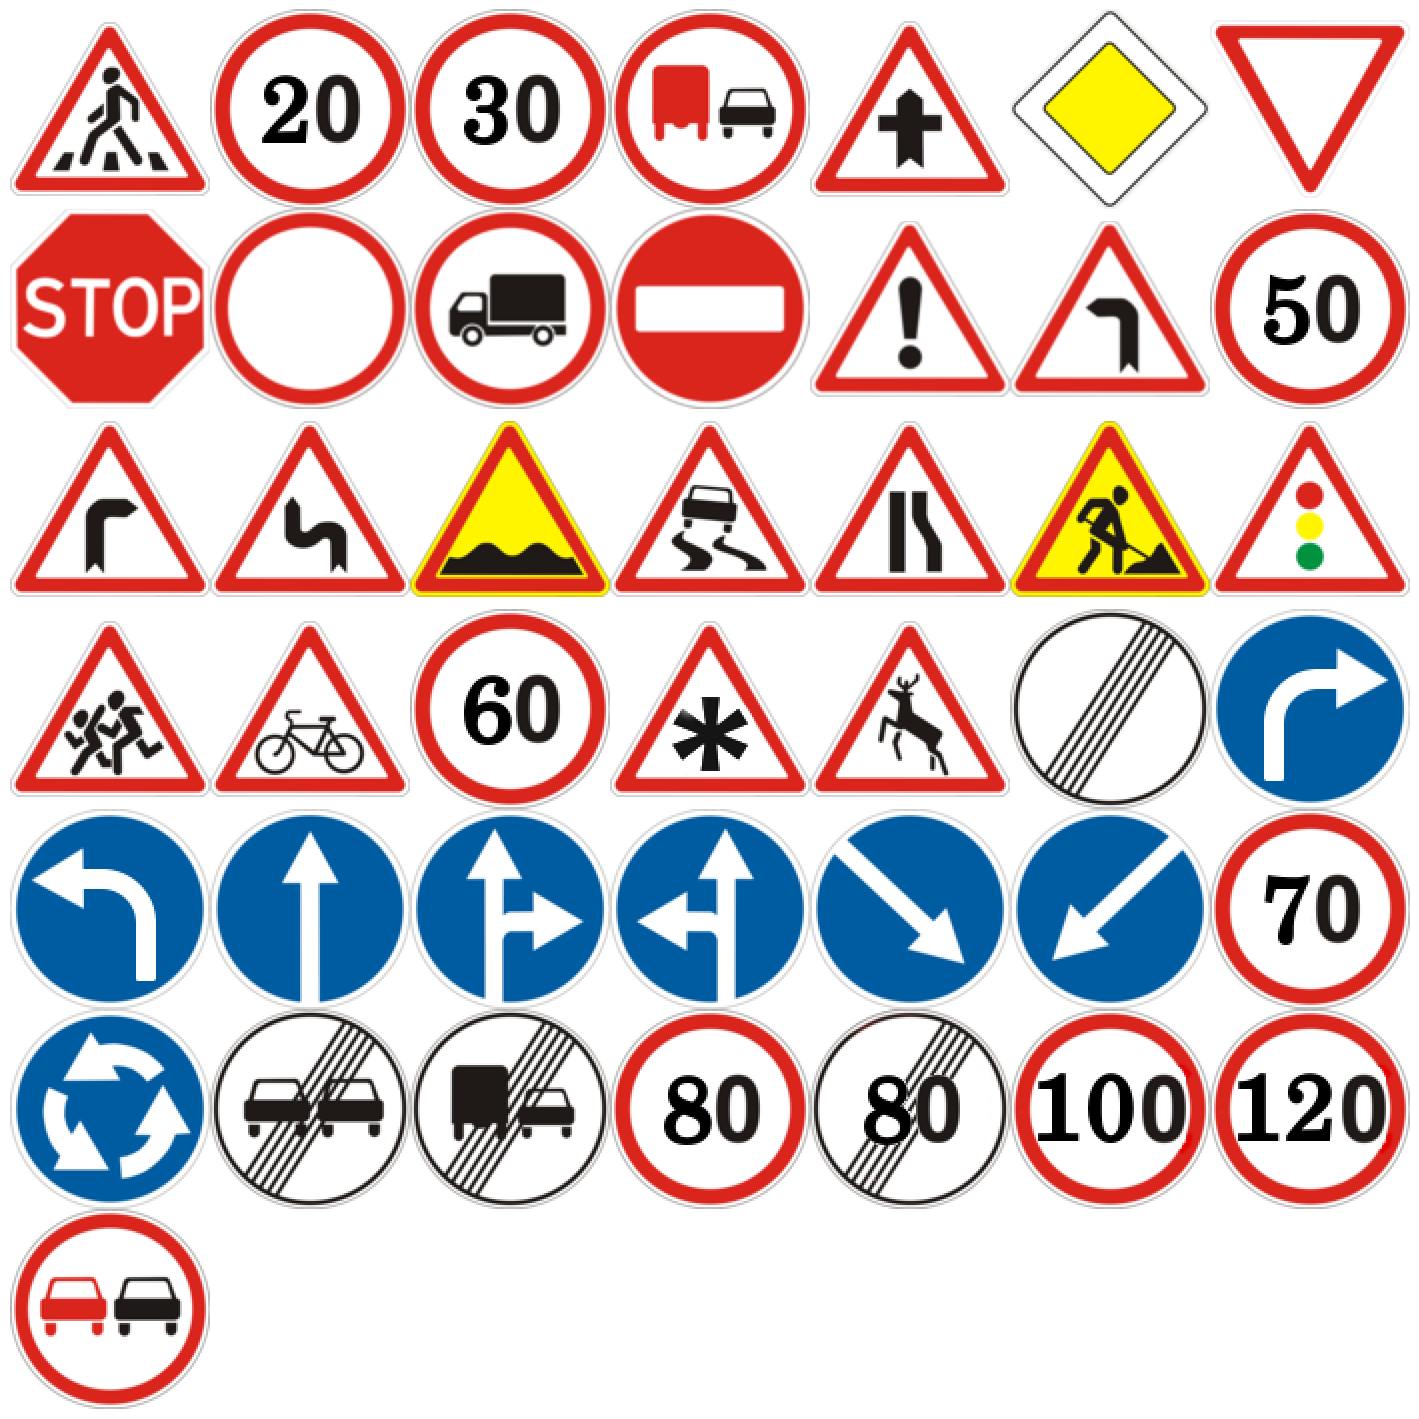

In [3]:
metabase = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Meta.csv')

def afficher_images(df, path_column, num_images_total=43):
    paths = df[path_column].tolist()
    
    num_cols = math.ceil(math.sqrt(num_images_total))  
    num_rows = math.ceil(num_images_total / num_cols)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 2, num_rows * 2))

    for i in range(num_rows * num_cols):
        ax = axes[i // num_cols, i % num_cols]
        if i < num_images_total:
            try:
                img = plt.imread(f"/kaggle/input/gtsrb-german-traffic-sign/{paths[i]}")
                ax.imshow(img)
                ax.axis('off')
            except Exception as e:
                ax.text(0.5, 0.5, f"Erreur d'affichage de l'image {i+1}", ha='center', va='center')
                print(f"Erreur d'affichage de l'image {i+1}: {str(e)}")
        else:
            ax.axis('off')

    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
    plt.show()

afficher_images(metabase, 'Path', num_images_total=43)

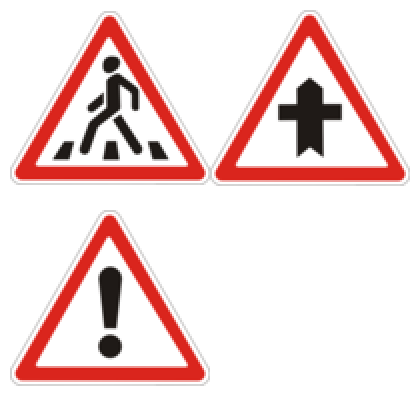

In [4]:
def afficher_images_per_shape(df, num_images=3):
    filtered_df = df[df['ShapeId'] == 0]
    afficher_images(filtered_df, 'Path', num_images)
    
afficher_images_per_shape(metabase)

### 1.2 Id checked ✅
- ShapeId : 0-triangle, 1-circle, 2-diamond, 3-hexagon, 4-inverse triangle  
- ColorId : 0-red, 1-blue, 2-yellow, 3-white

## 2. **Préparation des Données**
### 2.1 Définition de la taille
- Les largeurs d'image sont principalement comprises entre 25 et 61 pixels, représentant environ 79 % des données (9 985 images sur 12 630).  
- Les hauteurs d'image sont également principalement comprises entre 25 et 66 pixels, représentant environ 83 % des données (10 432 images sur 12 630).  
`-->` 64x64 pixels couvre la majorité des images (au moins 80 % des données).

### 2.2 Redimensionnement et Normalisation

In [5]:
data = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')
merged_data = data.merge(metabase[['ClassId', 'ShapeId', 'ColorId']], on='ClassId', how='left')

def load_and_preprocess_images(metadata, target_size=(64, 64)):
    images = []
    labels = []
    
    for index, row in metadata.iterrows():
        img_path = f"/kaggle/input/gtsrb-german-traffic-sign/{row['Path']}"
        class_id = row['ClassId']
        
        img = cv2.imread(img_path)                                   
        
        if img is None:                                              
            print(f"Erreur de chargement de l'image à {img_path}")
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)          # Redimensionnement
        
        images.append(img)
        labels.append(class_id)

    return np.array(images), np.array(labels)

X, y = load_and_preprocess_images(merged_data)

print(f"Nombre d'images chargées: {X.shape[0]}")
print(f"Dimensions de chaque image: {X.shape[1:]}")
print(f"Nombre d'étiquettes: {y.shape[0]}")
print(f"Valeurs min et max de X: {X.min()}, {X.max()}")

Nombre d'images chargées: 12630
Dimensions de chaque image: (64, 64, 3)
Nombre d'étiquettes: 12630
Valeurs min et max de X: 0, 255


### 2.3 Datasplit
* Train (70%)
* Val (15%)
* Test (15%)

In [6]:
# Stratification multiple (couleur, forme, classe)
merged_data['Stratifier'] = merged_data['ClassId'].astype(str) + '_' + merged_data['ShapeId'].astype(str) + '_' + merged_data['ColorId'].astype(str)

# Datasplit
X_train, X_temp, y_train, y_temp = train_test_split(X, merged_data['Stratifier'], test_size=0.30, random_state=42, stratify=merged_data['Stratifier'])
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Extraction de ClassId
y_train = [label.split('_')[0] for label in y_train]
y_val = [label.split('_')[0] for label in y_val]
y_test = [label.split('_')[0] for label in y_test]


print("Shapes des datasets après division :")
print(f"\nX_train shape: {X_train.shape}, y_train shape: {np.array(y_train).shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {np.array(y_val).shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {np.array(y_test).shape}")

print("\nNombre de classes uniques dans y_train :", len(np.unique(y_train)))
print("Nombre de classes uniques dans y_val :", len(np.unique(y_val)))
print("Nombre de classes uniques dans y_test :", len(np.unique(y_test)))


Shapes des datasets après division :

X_train shape: (8841, 64, 64, 3), y_train shape: (8841,)
X_val shape: (1894, 64, 64, 3), y_val shape: (1894,)
X_test shape: (1895, 64, 64, 3), y_test shape: (1895,)

Nombre de classes uniques dans y_train : 43
Nombre de classes uniques dans y_val : 43
Nombre de classes uniques dans y_test : 43


### Augmentation des images
- Rotation aléatoire à 90° : Les images peuvent être pivotées de 90°, 180° ou 270° de manière aléatoire.
- Flip vertical : Les images peuvent être retournées verticalement.
- Transposition : Les axes de l'image peuvent être échangés.
- Déplacement, échelle, et rotation aléatoire : L'image peut être légèrement décalée (10% max), redimensionnée (±10%) ou tournée jusqu'à 45°, avec une probabilité de 50%.
- Luminosité et contraste aléatoires : Ajuste la luminosité (±20%) et le contraste (±20%) avec une probabilité de 50%.
- Bruit gaussien : Ajout de bruit gaussien avec une variance comprise entre 10 et 50, avec une probabilité de 50%.
- Modifications de teinte, saturation et valeur : Les couleurs de l'image peuvent être ajustées en termes de teinte (±20), saturation (±30) et valeur (±20), avec une probabilité de 50%.

Shape des images d'entraînement augmentées : (44205, 64, 64, 3)
Shape des images de validation augmentées : (1894, 64, 64, 3)
Shape des images de test augmentées : (1895, 64, 64, 3)


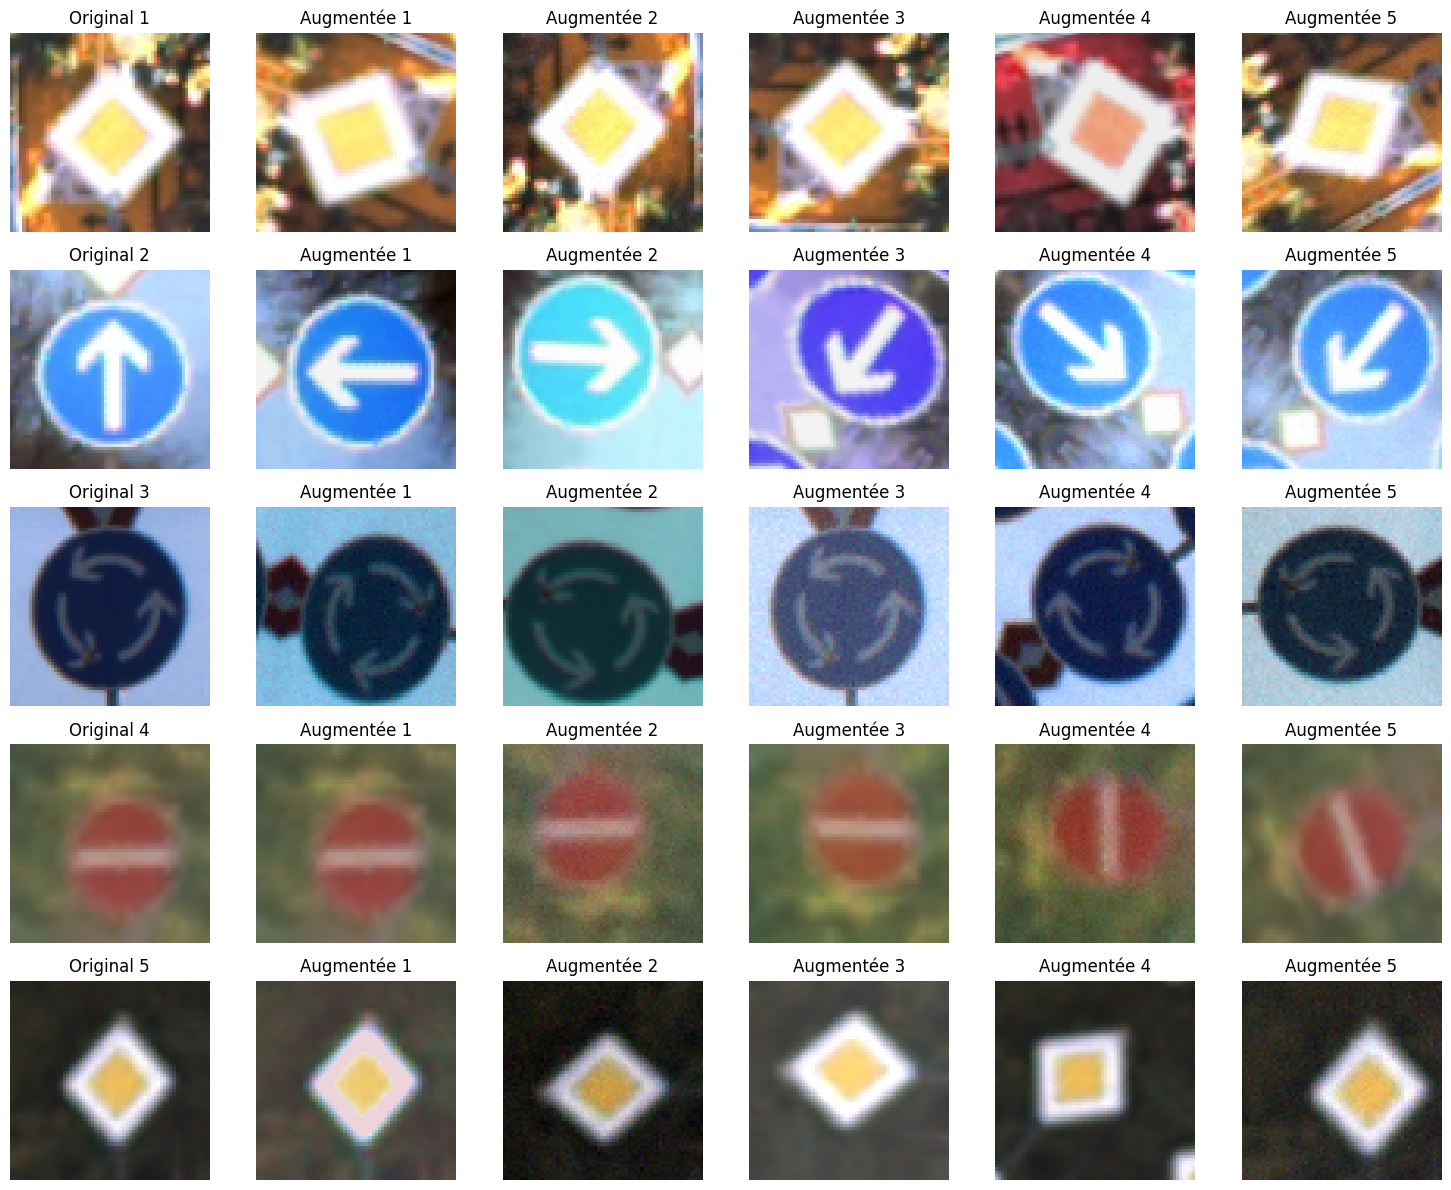

In [7]:
def augment_images(images, num_augmentations=5):
    transform = A.Compose([
        A.RandomRotate90(),
        A.VerticalFlip(),
        A.Transpose(),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussNoise(var_limit=(10, 50), p=0.5),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        A.Resize(64, 64)  
    ])
    
    augmented_images = []
    
    for image in images:
        for _ in range(num_augmentations):
            augmented = transform(image=image)['image']  
            augmented_images.append(augmented)
    
    return augmented_images

nb_augm_per_image = 5  # Nombre d'augmentations par image
augmented_X_train = augment_images(X_train, num_augmentations=nb_augm_per_image)

print("Shape des images d'entraînement augmentées :", np.array(augmented_X_train).shape)
print("Shape des images de validation augmentées :", np.array(X_val).shape)
print("Shape des images de test augmentées :", np.array(X_test).shape)

def duplicate_labels(labels, num_augmentations=5):
    """Duplique chaque label autant de fois que le nombre d'augmentations (pour y)"""
    return np.repeat(labels, num_augmentations)

y_train = duplicate_labels(y_train)

def display_images(originals, augmented, num_augmentations=5):
    plt.figure(figsize=(15, 12))  
    
    num_examples = len(originals)
    
    for idx in range(num_examples):
        
        plt.subplot(num_examples, num_augmentations + 1, idx * (num_augmentations + 1) + 1)  # original
        plt.imshow(originals[idx])
        plt.title(f'Original {idx + 1}')
        plt.axis('off')

        for i in range(num_augmentations):
            plt.subplot(num_examples, num_augmentations + 1, idx * (num_augmentations + 1) + i + 2) # augmented
            plt.imshow(augmented[idx * num_augmentations + i])
            plt.title(f'Augmentée {i + 1}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_images(X_train[:5], augmented_X_train[:5 * 5], num_augmentations=5)

In [8]:
def normalize_images(images):
    """
    Normalise les images en les mettant dans l'intervalle [0, 1].
    """
    return np.array(images) / 255.0

X_train = normalize_images(augmented_X_train)
X_val = normalize_images(X_val)
X_test = normalize_images(X_test)

print("Shape des images d'entraînement augmentées et normalisées :", X_train.shape, np.array(y_train).shape)
print(f"Valeurs min et max de X_train: {X_train.min()}, {X_train.max()}")

print("\nShape des images de validation augmentées et normalisées :", X_val.shape, np.array(y_val).shape)
print(f"Valeurs min et max de X_val: {X_val.min()}, {X_val.max()}")

print("\nShape des images de test augmentées et normalisées :", X_test.shape, np.array(y_test).shape)
print(f"Valeurs min et max de X_test: {X_test.min()}, {X_test.max()}")

# Conversion des labels en format `one-hot encoded`
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

Shape des images d'entraînement augmentées et normalisées : (44205, 64, 64, 3) (44205,)
Valeurs min et max de X_train: 0.0, 1.0

Shape des images de validation augmentées et normalisées : (1894, 64, 64, 3) (1894,)
Valeurs min et max de X_val: 0.0, 1.0

Shape des images de test augmentées et normalisées : (1895, 64, 64, 3) (1895,)
Valeurs min et max de X_test: 0.0, 1.0


## 3. **Conception et Implémentation de CNN Models**
### Architecture de base CNN

Une architecture de réseau de neurones convolutifs (CNN) est composée de plusieurs types de couches :

* Couches convolutives (Convolution Layers) : Ces couches appliquent des filtres pour extraire des caractéristiques spatiales et de texture d'une image. Plus il y a de couches convolutives, plus le réseau extrait des caractéristiques abstraites et complexes.
* Couches de Pooling : Utilisées pour réduire la dimensionnalité tout en conservant les caractéristiques importantes. Le MaxPooling est le plus couramment utilisé, qui sélectionne le maximum de chaque sous-région.
* Couches Fully Connected (Dense) : Elles transforment la sortie des couches convolutives en un vecteur pour effectuer la classification finale. Elles sont souvent utilisées en fin de réseau pour prendre une décision basée sur les caractéristiques extraites par les couches précédentes.

* Techniques de régularisation (Dropout, Batch Normalization).
    - Dropout : Cette technique consiste à ignorer aléatoirement une fraction des neurones pendant l'entraînement, empêchant le réseau de sur-apprendre des motifs spécifiques aux données d'entraînement.  
    - Batch Normalization : Elle normalise les activations des couches intermédiaires, réduisant ainsi la covariance interne des variables. Cela accélère l'entraînement et améliore la robustesse du modèle.  

## 4. **Entraînement du Modèle**
  - Définition des paramètres d’entraînement (fonction de coût, optimiseur).
  - Suivi des performances sur l’ensemble de validation (overfitting).
  
## 5. **Évaluation du Modèle**
  - Calcul des métriques.
  - Matrice de confusion et courbe de precision-recall

`NOTE: Dans l'objectif de synthétiser le code et de réaliser un benchmark entre différentes architectures, les phases 3, 4 et 5 sont réalisés en même temps sur 4 architectures différentes:`

### Comparaison d’architectures : du simple au complexe (VGG, ResNet)

* Version 1 : Une architecture simple avec des couches de base.
* Version 2 : Une architecture avec des techniques de régularisation.
* Version 3 : Apprentissage par transfert avec ResNet50 pré-entraîné.
* Version 4 : Une architecture inspirée de ResNet conçue à partir de zéro.

In [9]:
models_to_run = {
    "simple": True,
    "regularized": True,
    "transfer": True,
    "resnet": True,
}

### a) *TrafficSignModel* - Architecture class
Une classe de base est définie pour encapsuler la logique commune à tous les modèles, incluant :
- La construction du modèle (`build_model`)
- La compilation avec un optimiseur
- L'entraînement et l'évaluation via des métriques de performance comme la précision, le rappel, et l'AUC-ROC.

Cela permet de standardiser l'entraînement et l'évaluation pour toutes les versions de modèles testées.

In [10]:
reports = {}

class TrafficSignModel:
    def __init__(self, model_name, input_shape, num_classes):
        self.model_name = model_name
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()
        self.history = None

    def build_model(self):
        """Méthode à redéfinir dans les sous-classes pour construire des modèles spécifiques"""
        raise NotImplementedError

    def compile_model(self, optimizer='adam', learning_rate=0.001):
        """Compile le modèle avec une fonction de perte et des métriques"""
        self.model.compile(optimizer=optimizer, 
                           loss='categorical_crossentropy',                          # Loss function
                           metrics=['accuracy'])                                     # Metrics

    def fit(self, X_train, y_train, validation_data=None, epochs=10, batch_size=32, callbacks=None):
        """Entraîne le modèle sur les données fournies"""
        self.history = self.model.fit(X_train, y_train, 
                                      validation_data=validation_data,  
                                      epochs=epochs,                    
                                      batch_size=batch_size,        
                                      callbacks=callbacks) 
    
    def evaluate_model(self, X_test, y_test):
        """Évalue le modèle sur un ensemble de test et renvoie les métriques"""
        print(f"--- Performance Metrics for {self.model_name} ---")
        
        y_pred_prob = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(self.num_classes)], output_dict=True)

        report_df = pd.DataFrame(report).transpose()
        report_df = report_df.round(3)  

        accuracy = report_df.loc['accuracy'].to_frame().T
        macro_avg = report_df.loc[['macro avg']].copy()
        weighted_avg = report_df.loc[['weighted avg']].copy()
        auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
        avg_precision = average_precision_score(y_test, y_pred_prob, average='macro')

        metrics_df = pd.concat([accuracy, macro_avg, weighted_avg], axis=0)
        metrics_df.loc['AUC-ROC'] = auc_roc
        metrics_df.loc['Average Precision'] = avg_precision

        cm = confusion_matrix(y_true, y_pred)
        self.plot_confusion_matrix_and_pr(cm, y_true, y_pred_prob)

        print(metrics_df)
        return metrics_df

    def plot_confusion_matrix(self, cm):
        """Affiche une matrice de confusion avec seaborn"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for {self.model_name}')
    
    def plot_precision_recall(self, y_true, y_pred_prob):
        """Affiche les courbes de précision-rappel pour chaque classe"""
        plt.figure(figsize=(10, 8))
        for i in range(self.num_classes):
            precision, recall, _ = precision_recall_curve(y_true == i, y_pred_prob[:, i])
            pr_auc = auc(recall, precision)
            plt.plot(recall, precision, lw=2, label=f'Class {i} (AUC = {pr_auc:.2f})')

        plt.title('Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.tight_layout()
    
    def plot_confusion_matrix_and_pr(self, cm, y_true, y_pred_prob):
        """Affiche la matrice de confusion à gauche et la courbe de précision-rappel à droite"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 12))  

        # Matrice de confusion
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('True')
        axes[0].set_title(f'Confusion Matrix for {self.model_name}')

        # Courbes de précision-rappel
        for i in range(self.num_classes):
            precision, recall, _ = precision_recall_curve(y_true == i, y_pred_prob[:, i])
            pr_auc = auc(recall, precision)
            axes[1].plot(recall, precision, lw=2, label=f'Class {i} (AUC = {pr_auc:.2f})')

        axes[1].set_title('Precision-Recall curve')
        axes[1].set_xlabel('Recall')
        axes[1].set_ylabel('Precision')
        axes[1].legend()
        plt.tight_layout()
        plt.show()

### b) *TrafficSignModel* - Overfitting monitoring
Un callback personnalisé (TrainingPlot) est défini pour surveiller l'accuracy et la perte d'entraînement et de validation à chaque epoch. Ce mécanisme permet de détecter l'overfitting et d'interrompre l'entraînement si nécessaire via l'arrêt précoce (early stopping).

In [11]:
class TrainingPlot(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.max_acc = 0
    
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.max_acc = max(self.max_acc, logs.get('val_accuracy'))
        
        if len(self.losses) > 1:
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            plt.figure(figsize=(10,5))
            plt.plot(N, self.losses, lw=2, c="b", linestyle="-", label="train_loss")
            plt.plot(N, self.acc, lw=2, c="r", linestyle="-", label="train_acc")
            plt.plot(N, self.val_losses, lw=2, c="b", linestyle=":", label="val_loss")
            plt.plot(N, self.val_acc, lw=2, c="r", linestyle=":", label="val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}, Max Acc {:.4f}]".format(epoch + 1, self.max_acc))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

### c) *TrafficSignModel* - Model version 1 (architecture simple)
Ce modèle simple est composé de deux couches convolutionnelles suivies de couches de pooling et de couches fully connected. Cette architecture de base sert de point de comparaison initial.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,630,699 (6.22 MB)

 Trainable params: 1,630,699 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

/opt/conda/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


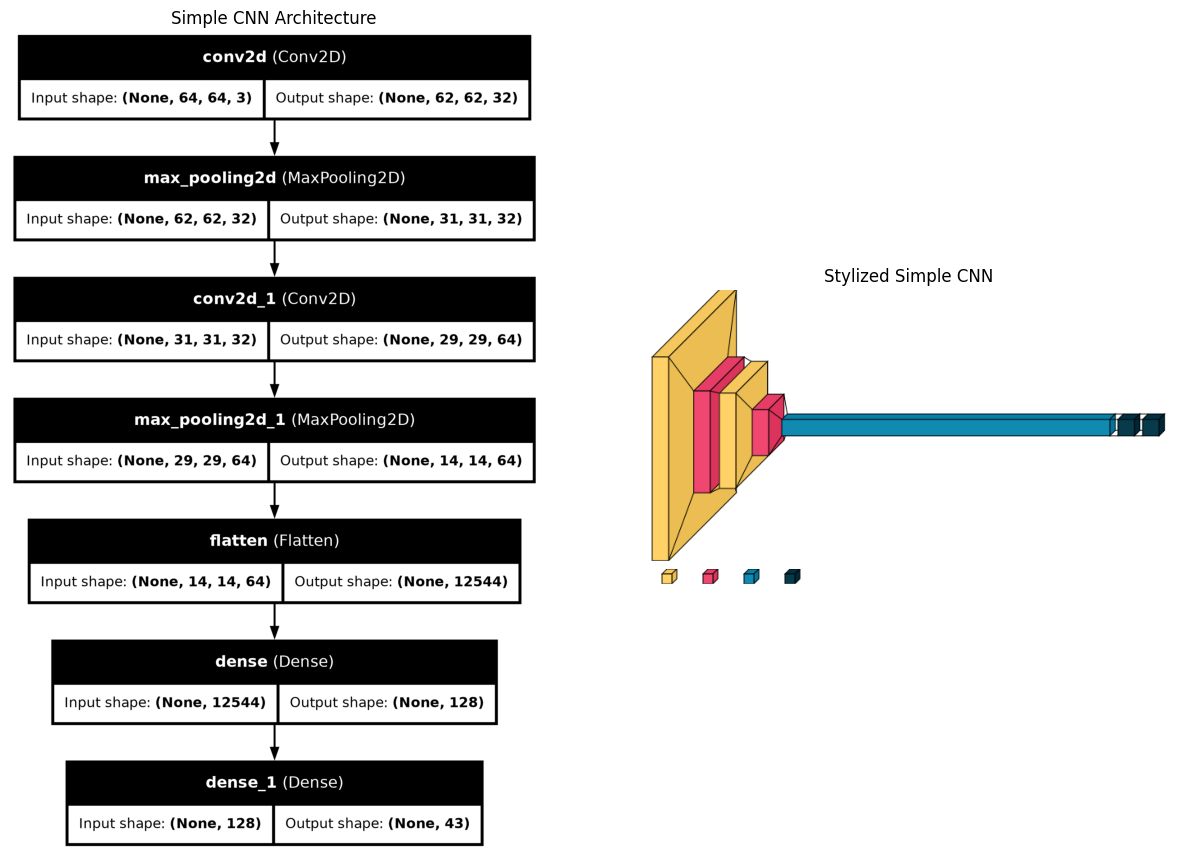

In [12]:
class SimpleCNN(TrafficSignModel):
    def build_model(self):
        model = Sequential()
        model.add(Input(shape=self.input_shape))  
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.num_classes, activation='softmax'))
        return model

if models_to_run["simple"]:
    
    model = SimpleCNN(model_name="Simple CNN", input_shape=(64, 64, 3), num_classes=43)
    model.compile_model(optimizer='adam', learning_rate=0.001)
    model.model.summary()
    
    # Générer l'architecture avec plot_model
    os.makedirs('/kaggle/working/architecture/', exist_ok=True)
    plot_model(model.model, to_file='/kaggle/working/architecture/simple_cnn_architecture.png', show_shapes=True, show_layer_names=True)

    # Générer le schéma avec visualkeras
    stylized_img = visualkeras.layered_view(model.model, legend=True)  
    stylized_img.save('/kaggle/working/architecture/simple_cnn_stylized.png')  

    fig, axs = plt.subplots(1, 2, figsize=(15, 20))

    # Charger et afficher l'image de plot_model
    img1 = mpimg.imread('/kaggle/working/architecture/simple_cnn_architecture.png')
    axs[0].imshow(img1)
    axs[0].axis('off') 
    axs[0].set_title('Simple CNN Architecture')

    # Charger et afficher l'image de visualkeras
    img2 = mpimg.imread('/kaggle/working/architecture/simple_cnn_stylized.png')
    axs[1].imshow(img2)
    axs[1].axis('off')  
    axs[1].set_title('Stylized Simple CNN')

    plt.show()

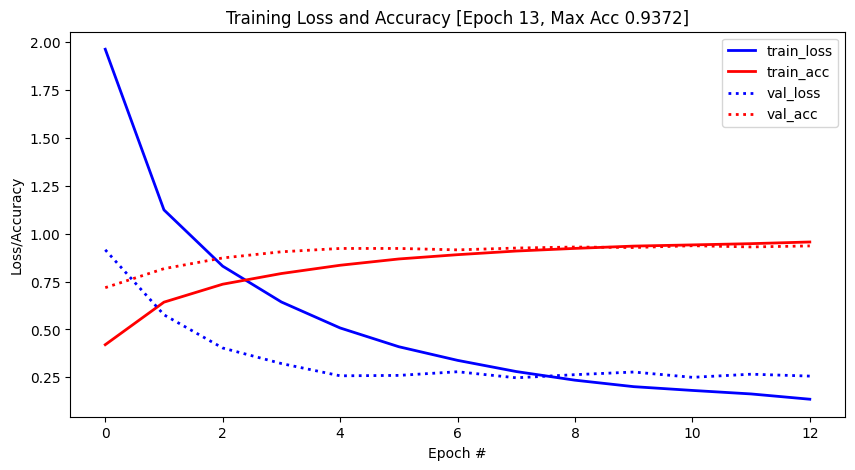

691/691 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9598 - loss: 0.1277 - val_accuracy: 0.9361 - val_loss: 0.2562
--- Performance Metrics for Simple CNN ---
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
                   precision    recall  f1-score      support
accuracy            0.940000  0.940000  0.940000     0.940000
macro avg           0.948000  0.934000  0.939000  1895.000000
weighted avg        0.942000  0.940000  0.940000  1895.000000
AUC-ROC             0.998819  0.998819  0.998819     0.998819
Average Precision   0.975021  0.975021  0.975021     0.975021


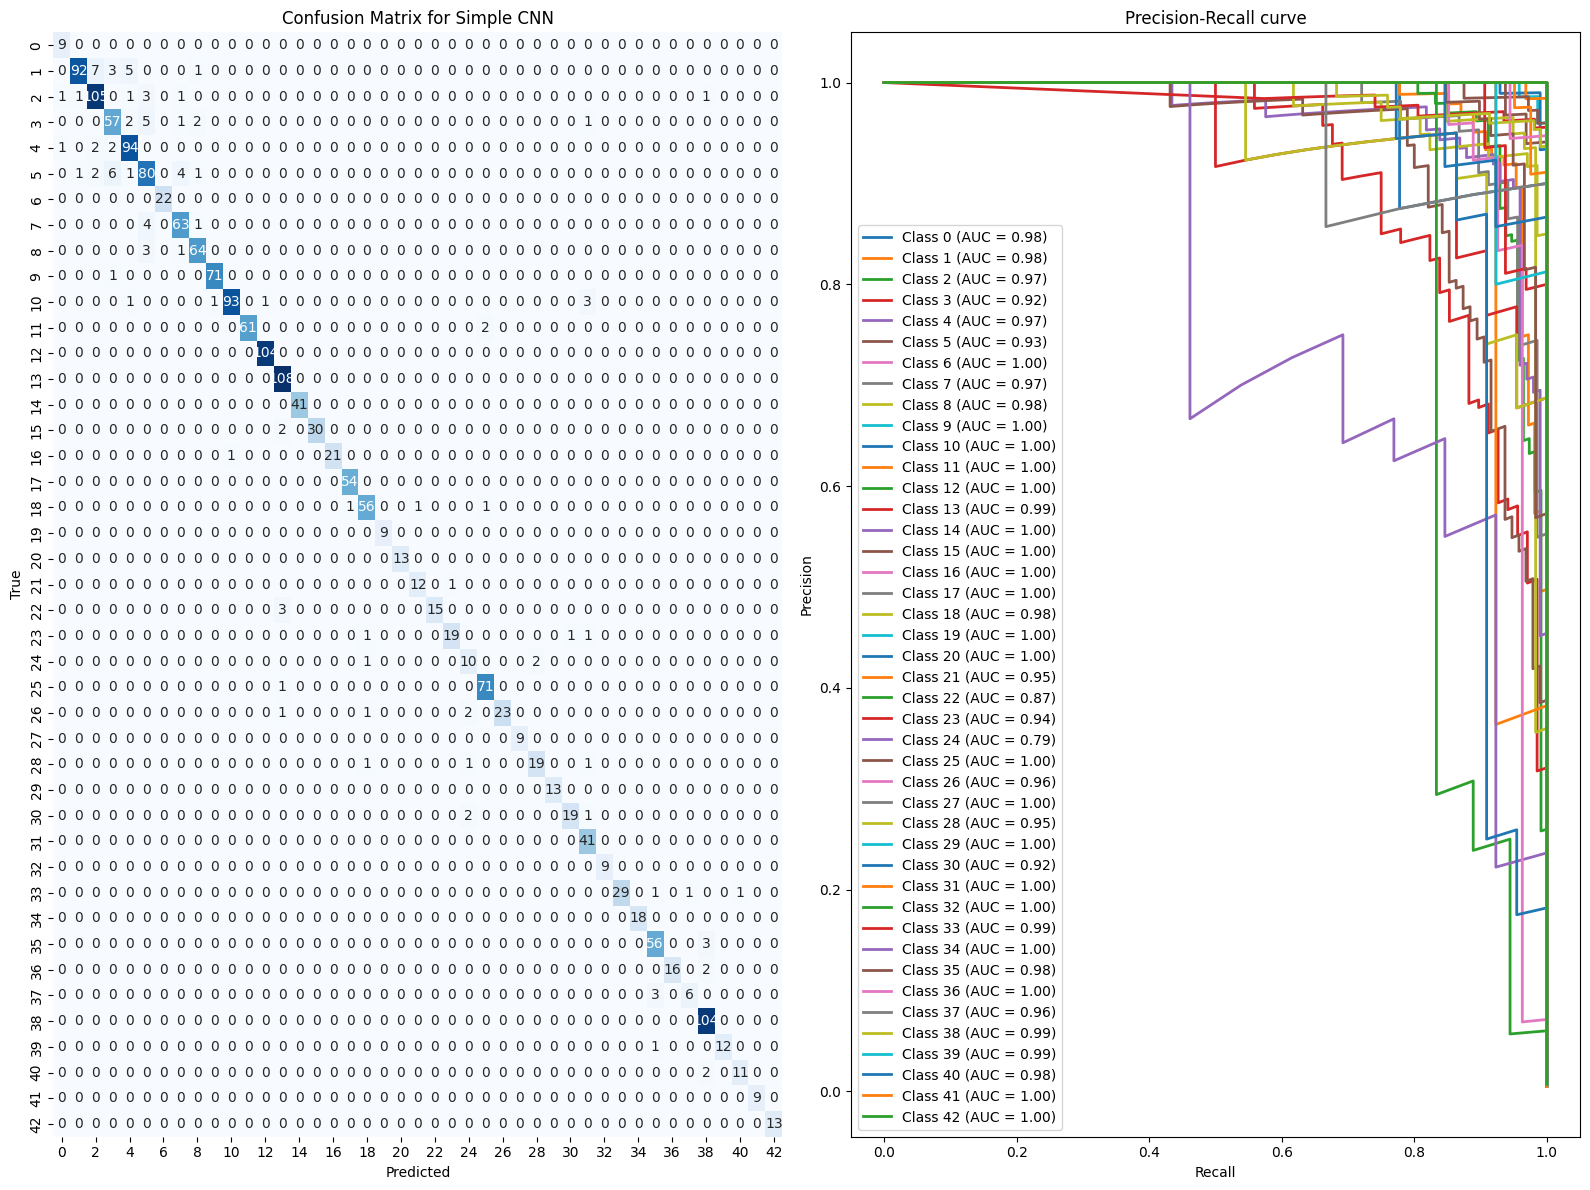

In [13]:
if models_to_run["simple"]:
    earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5,  restore_best_weights=False)
    plot_losses = TrainingPlot()  
    model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                     epochs=100, batch_size=64, callbacks=[plot_losses, earlystop])
    reports["simple"] = model.evaluate_model(X_test, y_test)

#### Analyse 
Le modèle simple fonctionne bien pour une architecture basique, atteignant une précision de 94%. Cependant, il présente des limites dues à son architecture peu profonde, notamment une légère baisse dans la capacité à généraliser.

### d) *TrafficSignModel* - Model version 2 (CNN avec regularization)
Cette version améliore l'architecture précédente en ajoutant des techniques de régularisation comme le Dropout et la Batch Normalization, afin de limiter l'overfitting.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 695,147 (2.65 MB)

 Trainable params: 694,699 (2.65 MB)

 Non-trainable params: 448 (1.75 KB)

/opt/conda/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


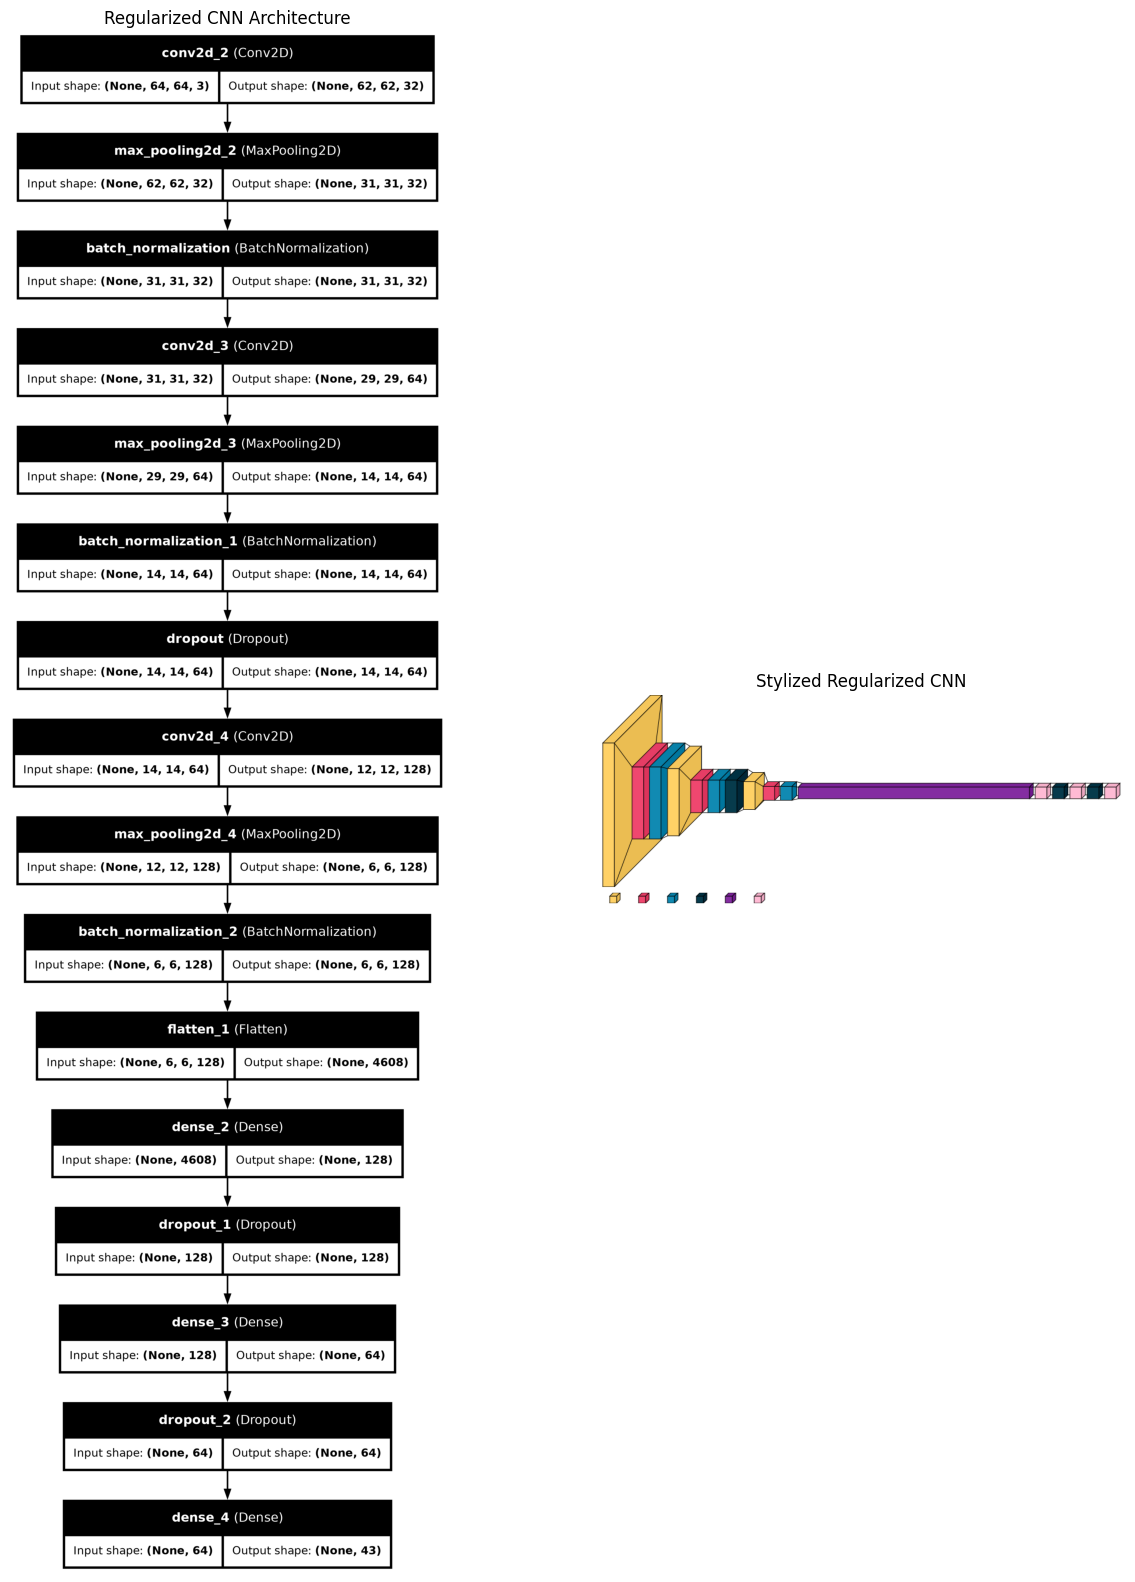

In [14]:
class RegularizedCNN(TrafficSignModel):
    def build_model(self):
        model = Sequential()
        model.add(Input(shape=self.input_shape))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal()))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal()))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())  
        model.add(Dropout(0.25))        

        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal()))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())

        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer=HeNormal()))
        model.add(Dropout(0.3))       

        model.add(Dense(64, activation='relu', kernel_initializer=HeNormal()))
        model.add(Dropout(0.3))

        model.add(Dense(self.num_classes, activation='softmax'))

        return model

if models_to_run["regularized"]:
    model = RegularizedCNN(model_name="Regularized CNN", input_shape=(64, 64, 3), num_classes=43)
    model.compile_model(optimizer='adam', learning_rate=0.001)
    model.model.summary()
    
    # Générer l'architecture avec plot_model
    os.makedirs('/kaggle/working/architecture/', exist_ok=True)
    plot_model(model.model, to_file='/kaggle/working/architecture/regularized_cnn_architecture.png', show_shapes=True, show_layer_names=True)

    # Générer un schéma avec visualkeras
    stylized_img = visualkeras.layered_view(model.model, legend=True)  
    stylized_img.save('/kaggle/working/architecture/regularized_cnn_stylized.png')  

    fig, axs = plt.subplots(1, 2, figsize=(15, 20))  

    # Image générée par plot_model
    img1 = mpimg.imread('/kaggle/working/architecture/regularized_cnn_architecture.png')
    axs[0].imshow(img1)
    axs[0].axis('off') 
    axs[0].set_title('Regularized CNN Architecture')

    # Image générée par visualkeras
    img2 = mpimg.imread('/kaggle/working/architecture/regularized_cnn_stylized.png')
    axs[1].imshow(img2)
    axs[1].axis('off')  
    axs[1].set_title('Stylized Regularized CNN')

    plt.show()

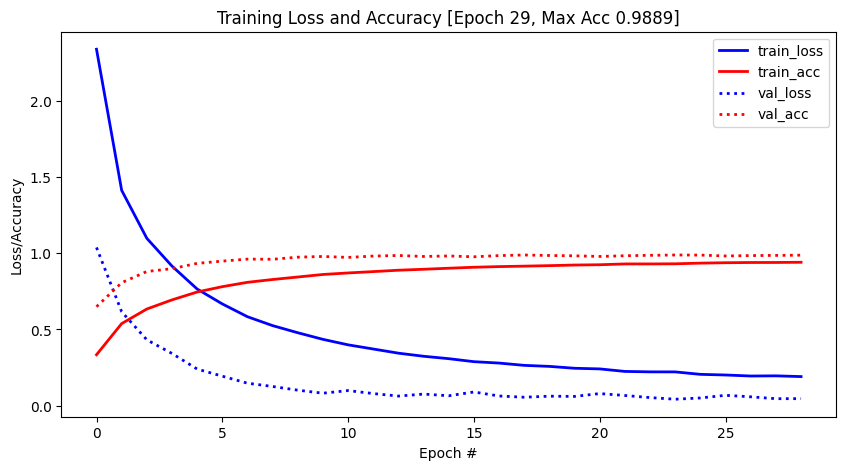

691/691 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9410 - loss: 0.1937 - val_accuracy: 0.9879 - val_loss: 0.0458
--- Performance Metrics for Regularized CNN ---
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
                   precision    recall  f1-score      support
accuracy            0.986000  0.986000  0.986000     0.986000
macro avg           0.990000  0.988000  0.989000  1895.000000
weighted avg        0.987000  0.986000  0.986000  1895.000000
AUC-ROC             0.999954  0.999954  0.999954     0.999954
Average Precision   0.998764  0.998764  0.998764     0.998764


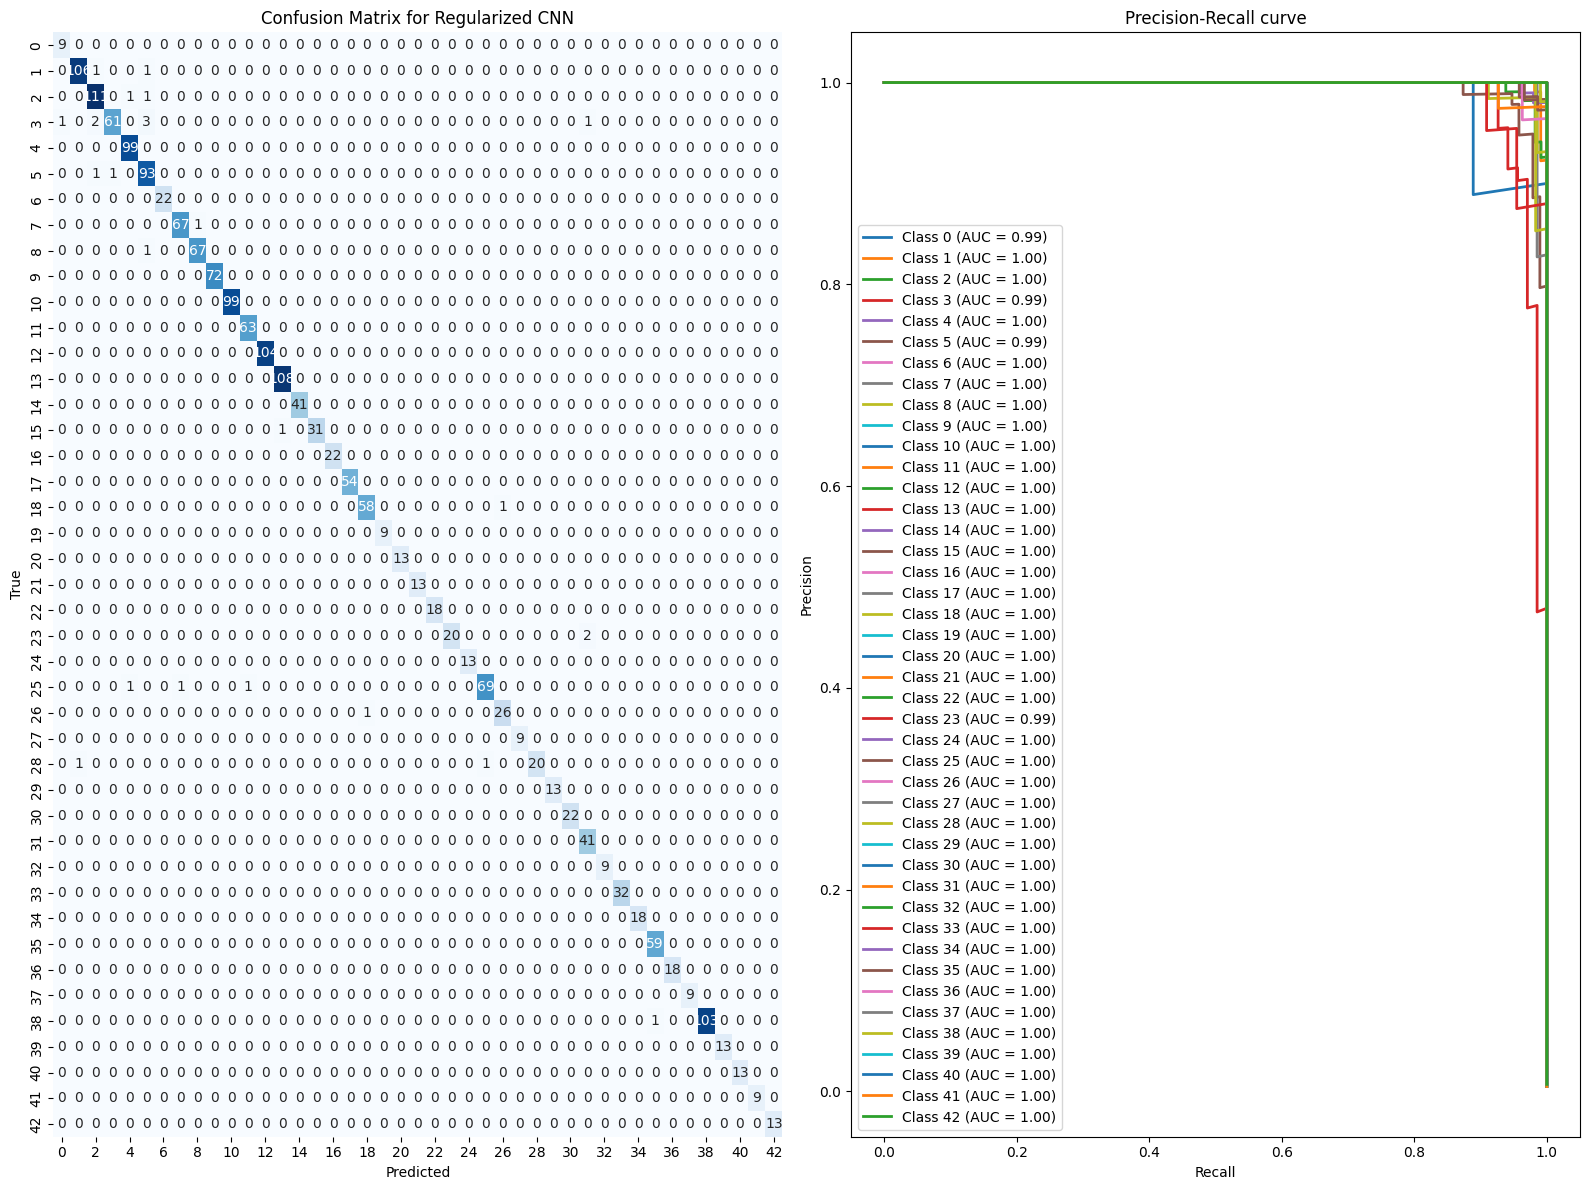

In [15]:
if models_to_run["regularized"]:
    earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5,  restore_best_weights=False)
    plot_losses = TrainingPlot()  
    model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                     epochs=100, batch_size=64, callbacks=[plot_losses, earlystop])
    reports["regularized"] = model.evaluate_model(X_test, y_test)

Conclusion : Le modèle régularisé atteint une accuracy en validation plus élevée (98.52%) avec un AUC-ROC quasi parfait de 99.99%, montrant l'efficacité des régularisations. Néanmoins, on observe que le modèle à tendance à sur-apprendre puisque qu'il à des difficultés à généraliser sur le jeu de validation.

### e) *TrafficSignModel* - Model version 3 (Transfer learning)
Cette version utilise ResNet50 pré-entraîné sur ImageNet, seules les dernières couches du modèle sont ajustées pour la tâche.

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,150,699 (92.13 MB)

 Trainable params: 5,028,651 (19.18 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

/opt/conda/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


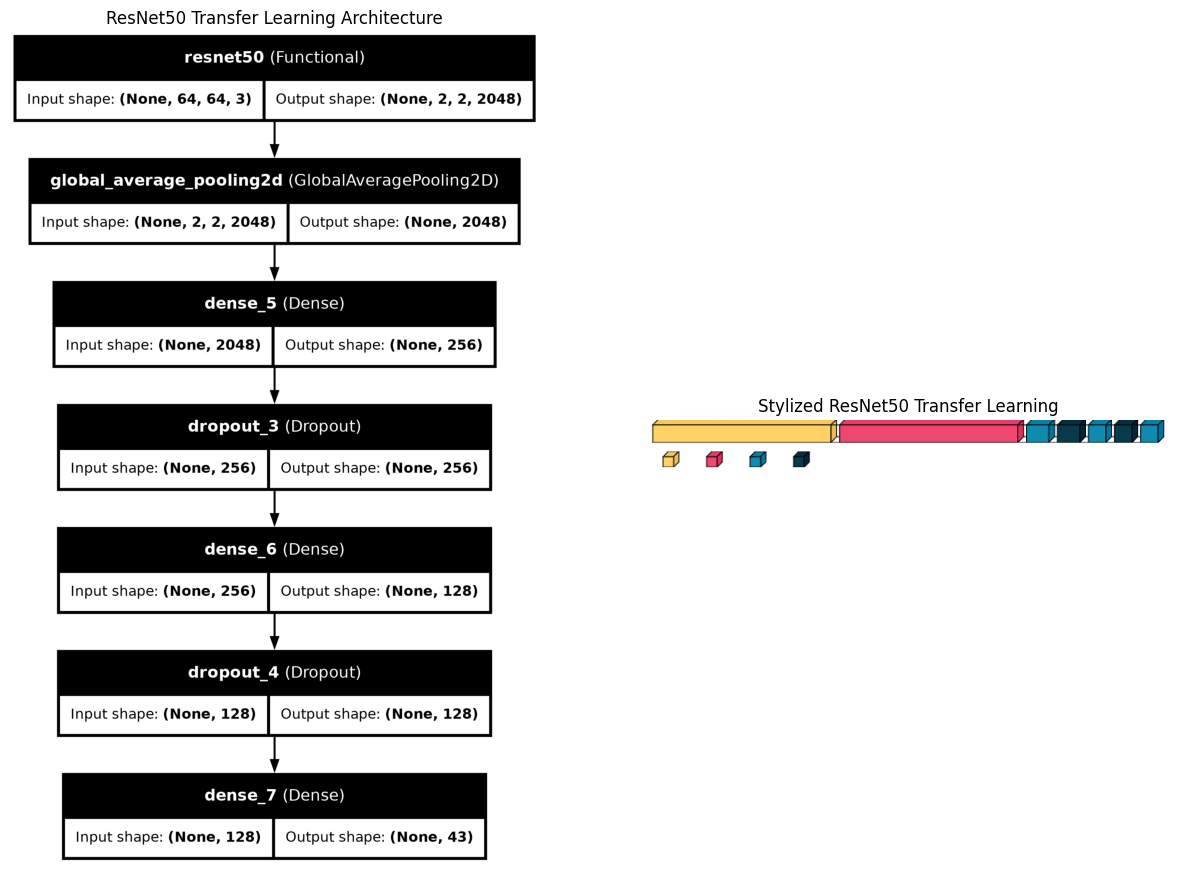

In [16]:
class TransferLearningModel:
    def __init__(self, base_model, input_shape, num_classes, model_name):
        self.base_model = base_model
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model_name = model_name
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Input(shape=self.input_shape))                  # Input
        model.add(self.base_model)                                # modèle de base
        model.add(GlobalAveragePooling2D())                       # GlobalAveragePooling ou Flatten
        model.add(Dense(256, activation='relu'))                  # Dense
        model.add(Dropout(0.5))                                   # Dropout
        model.add(Dense(128, activation='relu'))                  # Dense
        model.add(Dropout(0.25))                                  # Dropout
        model.add(Dense(self.num_classes, activation='softmax'))  # Output 
        return model

    def evaluate_model(self, X_test, y_test):
        """Évalue le modèle sur un ensemble de test et renvoie les métriques"""
        print(f"--- Performance Metrics for {self.model_name} ---")
        
        y_pred_prob = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(self.num_classes)], output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        report_df = report_df.round(3)

        accuracy = report_df.loc['accuracy'].to_frame().T
        macro_avg = report_df.loc[['macro avg']].copy()
        weighted_avg = report_df.loc[['weighted avg']].copy()
        auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
        avg_precision = average_precision_score(y_test, y_pred_prob, average='macro')

        metrics_df = pd.concat([accuracy, macro_avg, weighted_avg], axis=0)
        metrics_df.loc['AUC-ROC'] = auc_roc
        metrics_df.loc['Average Precision'] = avg_precision
        
        print(metrics_df)

        cm = confusion_matrix(y_true, y_pred)
        self.plot_confusion_matrix_and_pr(cm, y_true, y_pred_prob)
        return metrics_df

    def plot_confusion_matrix(self, cm):
        """Affiche une matrice de confusion avec seaborn"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for {self.model_name}')

    def plot_precision_recall(self, y_true, y_pred_prob):
        """Affiche les courbes de précision-rappel pour chaque classe"""
        plt.figure(figsize=(10, 8))
        for i in range(self.num_classes):
            precision, recall, _ = precision_recall_curve(y_true == i, y_pred_prob[:, i])
            pr_auc = auc(recall, precision)
            plt.plot(recall, precision, lw=2, label=f'Class {i} (AUC = {pr_auc:.2f})')

        plt.title('Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.tight_layout()

    def plot_confusion_matrix_and_pr(self, cm, y_true, y_pred_prob):
        """Affiche la matrice de confusion à gauche et la courbe de précision-rappel à droite"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 12))  

        # Matrice de confusion
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('True')
        axes[0].set_title(f'Confusion Matrix for {self.model_name}')

        # Courbes de précision-rappel
        for i in range(self.num_classes):
            precision, recall, _ = precision_recall_curve(y_true == i, y_pred_prob[:, i])
            pr_auc = auc(recall, precision)
            axes[1].plot(recall, precision, lw=2, label=f'Class {i} (AUC = {pr_auc:.2f})')

        axes[1].set_title('Precision-Recall curve')
        axes[1].set_xlabel('Recall')
        axes[1].set_ylabel('Precision')
        axes[1].legend()
        plt.tight_layout()
        plt.show()

if models_to_run["transfer"]:
    # Chargement de ResNet50 sans la couche de sortie et avec des poids pré-entraînés
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    for layer in base_model.layers:        # Geler toutes les couches sauf les 10 dernières
        layer.trainable = False

    for layer in base_model.layers[-10:]:  # Débloquer les 10 dernières couches
        layer.trainable = True

    model = TransferLearningModel(base_model=base_model, input_shape=(64, 64, 3), num_classes=43, model_name="ResNet50-fine-tunned")
    model.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                        loss='categorical_crossentropy', 
                        metrics=['accuracy'])
    model.model.summary()
    
    # Schémas du model
    os.makedirs('/kaggle/working/architecture/', exist_ok=True)
    plot_model(model.model, to_file='/kaggle/working/architecture/resnet50_transfer_learning_architecture.png', show_shapes=True, show_layer_names=True)

    stylized_img = visualkeras.layered_view(model.model, legend=True)  
    stylized_img.save('/kaggle/working/architecture/resnet50_transfer_learning_stylized.png')  

    fig, axs = plt.subplots(1, 2, figsize=(15, 20)) 
    
    img1 = mpimg.imread('/kaggle/working/architecture/resnet50_transfer_learning_architecture.png')
    axs[0].imshow(img1)
    axs[0].axis('off') 
    axs[0].set_title('ResNet50 Transfer Learning Architecture')

    img2 = mpimg.imread('/kaggle/working/architecture/resnet50_transfer_learning_stylized.png')
    axs[1].imshow(img2)
    axs[1].axis('off')  
    axs[1].set_title('Stylized ResNet50 Transfer Learning')

    plt.show()

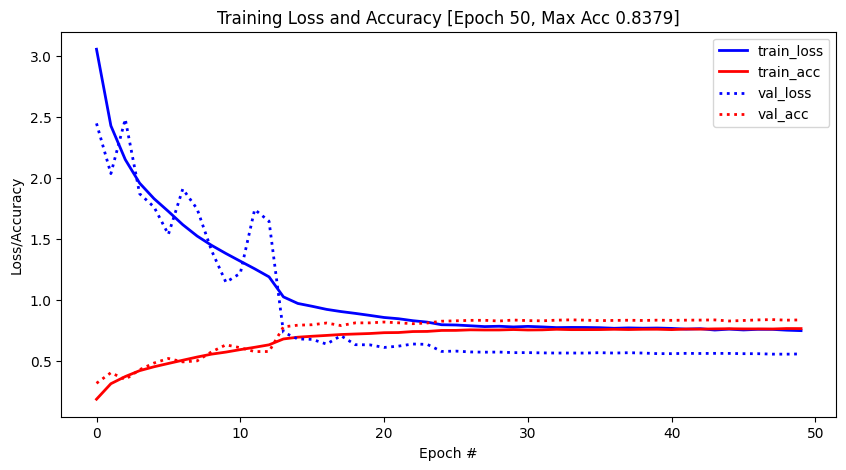

691/691 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.7670 - loss: 0.7347 - val_accuracy: 0.8353 - val_loss: 0.5563 - learning_rate: 1.0000e-06
--- Performance Metrics for ResNet50-fine-tunned ---
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step
                   precision    recall  f1-score      support
accuracy            0.842000  0.842000  0.842000     0.842000
macro avg           0.871000  0.817000  0.833000  1895.000000
weighted avg        0.847000  0.842000  0.839000  1895.000000
AUC-ROC             0.994055  0.994055  0.994055     0.994055
Average Precision   0.903645  0.903645  0.903645     0.903645


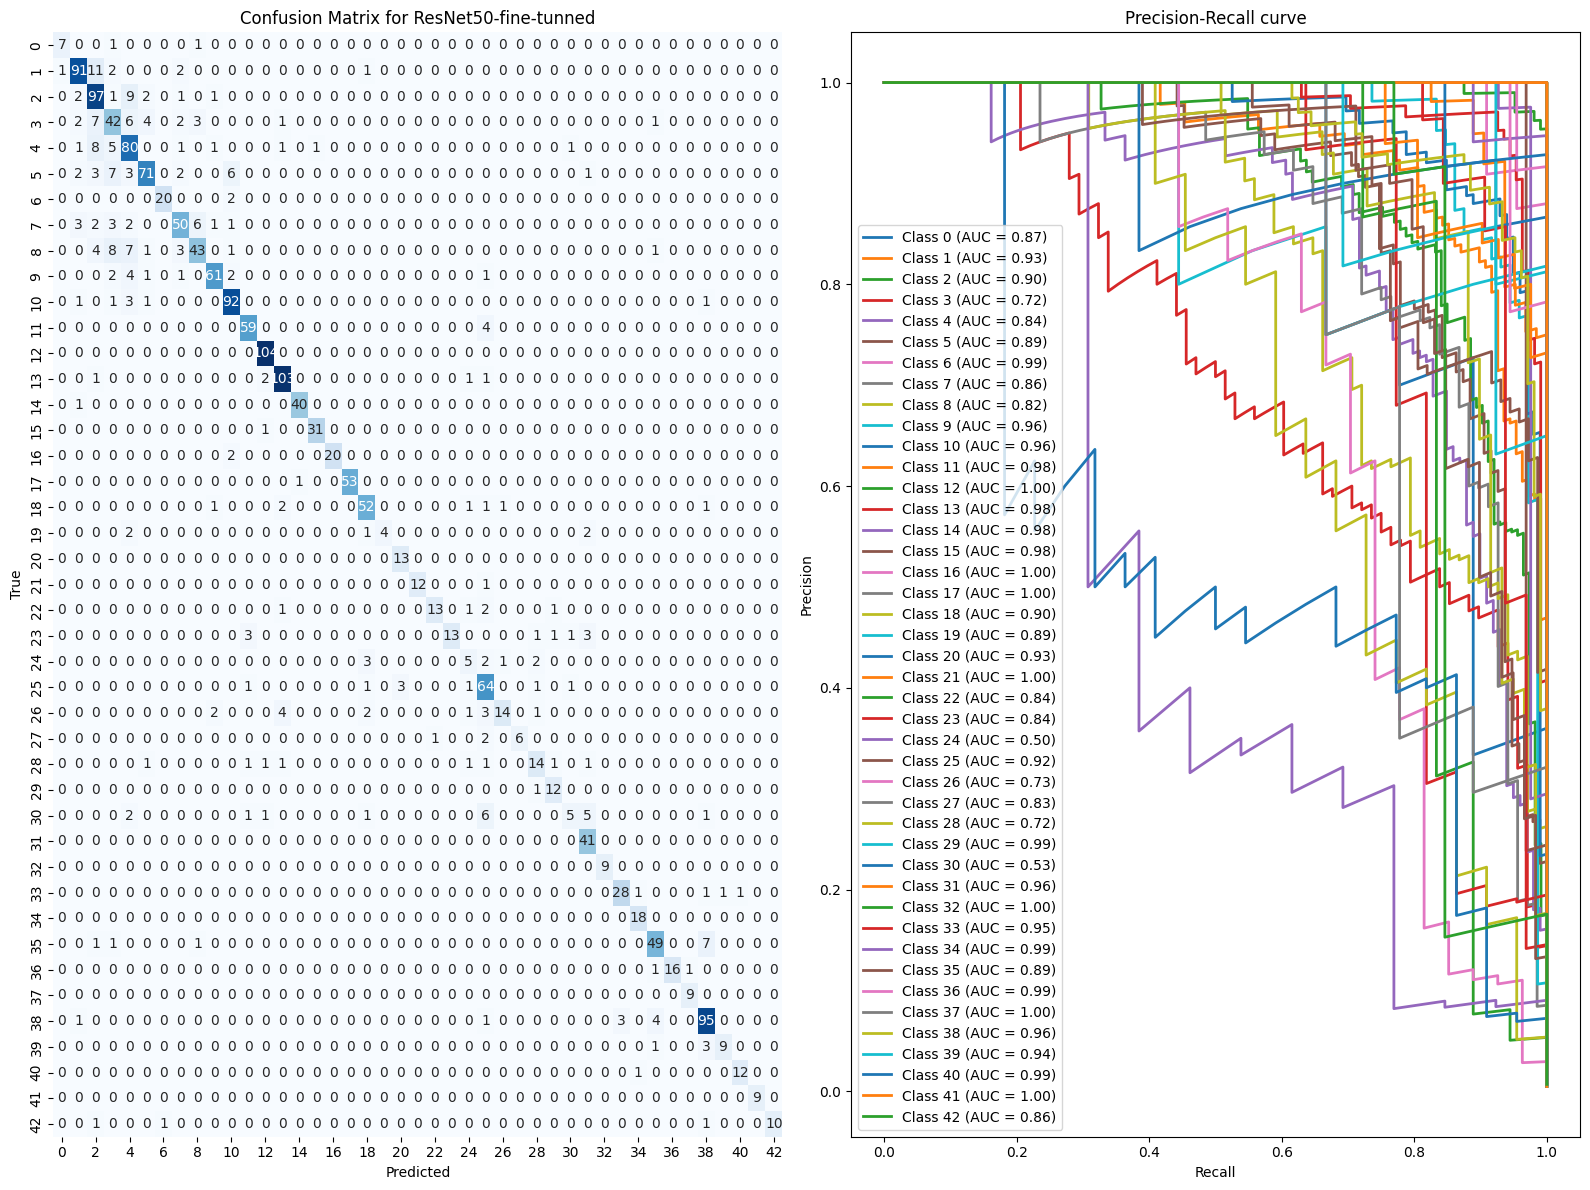

In [17]:
if models_to_run["transfer"]:
    earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
    plot_losses = TrainingPlot()  
    history = model.model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                              epochs=50, batch_size=64, 
                              callbacks=[reduce_lr, plot_losses, earlystop])
    reports["transfer"] = model.evaluate_model(X_test, y_test)

Le modèle actuellement défini démontre des performances inférieures aux précédents avec une précision de 84,2% et un AUC-ROC de 0.994. Cela peut s'expliquer par l'inadéquation possible entre le jeu d'entraînement (64x64 pixels) sachant que le modèle est entraîné initialement sur de plus grandes images(128, 256, ...).  
Un affinement de l'architecture et des hyperparamètres pourrait améliorer ces résultats. 

In [18]:
gc.collect()

136979

### f) *TrafficSignModel* - Model version 4 (architecture inspirée ResNet)
Le modèle inspiré de ResNet utilise des blocs résiduels pour faciliter l'apprentissage des réseaux plus profonds. L'idée clé des blocs résiduels est d'introduire des connections identitaires (shortcut connections) qui permettent de passer des gradients plus directement à travers le réseau, aidant à surmonter les problèmes de disparition des gradients dans des réseaux profonds.

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │      9,472 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     36,928 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 16, 16,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 128) │      8,320 │ re_lu_2[0][0]   

 Total params: 320,427 (1.22 MB)

 Trainable params: 319,531 (1.22 MB)

 Non-trainable params: 896 (3.50 KB)

/opt/conda/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


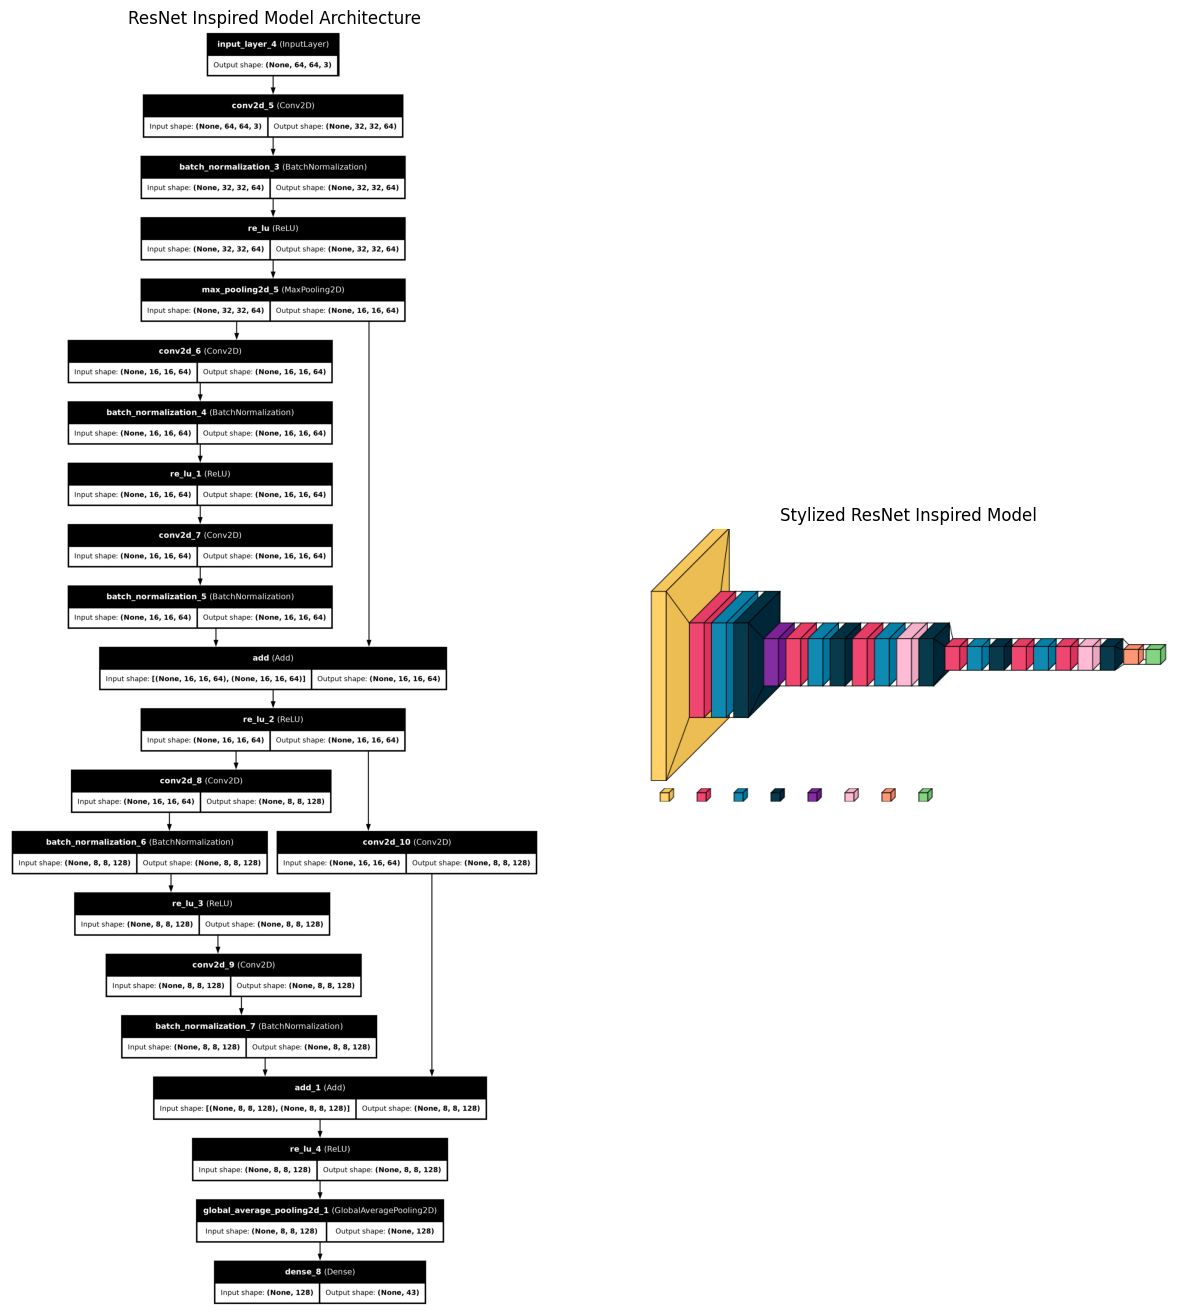

In [19]:
class ResNetInspiredModel(TrafficSignModel):
    def residual_block(self, x, filters, kernel_size=3, stride=1):
        shortcut = x  

        # Première couche conv avec initialisation HeNormal
        x = Conv2D(filters, kernel_size, strides=stride, padding='same', 
                   kernel_initializer=HeNormal())(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        # Deuxième couche conv avec initialisation HeNormal
        x = Conv2D(filters, kernel_size, strides=1, padding='same', 
                   kernel_initializer=HeNormal())(x)
        x = BatchNormalization()(x)

        # Si les dimensions changent, ajuster la shortcut
        if shortcut.shape[-1] != filters:
            shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same', 
                              kernel_initializer=HeNormal())(shortcut)

        # Addition de la shortcut connection
        x = Add()([x, shortcut])
        x = ReLU()(x)
        return x

    def build_model(self):
        inputs = Input(shape=self.input_shape)

        # Première convolution avec HeNormal
        x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', kernel_initializer=HeNormal())(inputs)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

        # Blocs résiduels
        x = self.residual_block(x, filters=64)
        x = self.residual_block(x, filters=128, stride=2)  # Réduction de la taille

        # Pooling global et sortie (dense avec HeNormal)
        x = GlobalAveragePooling2D()(x)
        outputs = Dense(self.num_classes, activation='softmax', kernel_initializer=HeNormal())(x)

        model = Model(inputs=inputs, outputs=outputs)
        return model
    
if models_to_run["resnet"]:
    model = ResNetInspiredModel(model_name="ResNetInspiredModel", input_shape=(64, 64, 3), num_classes=43)
    model.compile_model(optimizer='adam', learning_rate=0.001)
    model.model.summary()
    
    # Schémas du model
    os.makedirs('/kaggle/working/architecture/', exist_ok=True)
    plot_model(model.model, to_file='/kaggle/working/architecture/resnet_inspired_model_architecture.png', show_shapes=True, show_layer_names=True)

    stylized_img = visualkeras.layered_view(model.model, legend=True) 
    stylized_img.save('/kaggle/working/architecture/resnet_inspired_model_stylized.png')  

    fig, axs = plt.subplots(1, 2, figsize=(15, 20))  

    img1 = mpimg.imread('/kaggle/working/architecture/resnet_inspired_model_architecture.png')
    axs[0].imshow(img1)
    axs[0].axis('off') 
    axs[0].set_title('ResNet Inspired Model Architecture')

    img2 = mpimg.imread('/kaggle/working/architecture/resnet_inspired_model_stylized.png')
    axs[1].imshow(img2)
    axs[1].axis('off')  
    axs[1].set_title('Stylized ResNet Inspired Model')

    plt.show() 
    

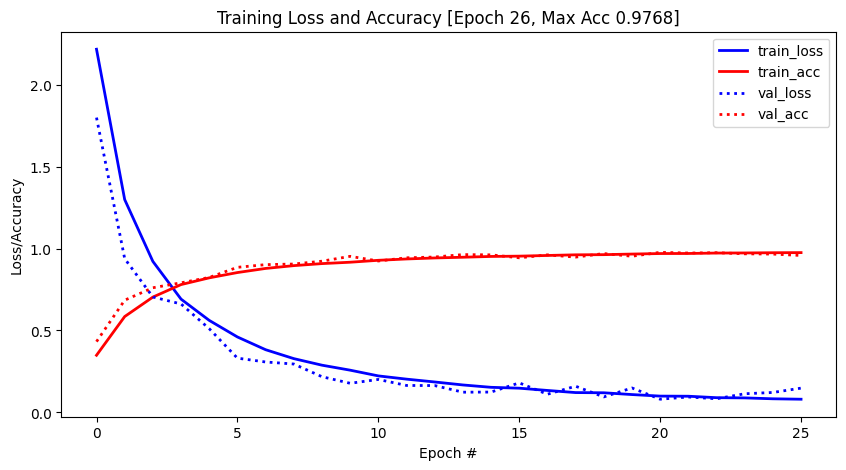

691/691 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9759 - loss: 0.0796 - val_accuracy: 0.9578 - val_loss: 0.1481
--- Performance Metrics for ResNetInspiredModel ---
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
                   precision    recall  f1-score      support
accuracy            0.947000  0.947000  0.947000     0.947000
macro avg           0.958000  0.932000  0.934000  1895.000000
weighted avg        0.953000  0.947000  0.946000  1895.000000
AUC-ROC             0.999692  0.999692  0.999692     0.999692
Average Precision   0.992974  0.992974  0.992974     0.992974


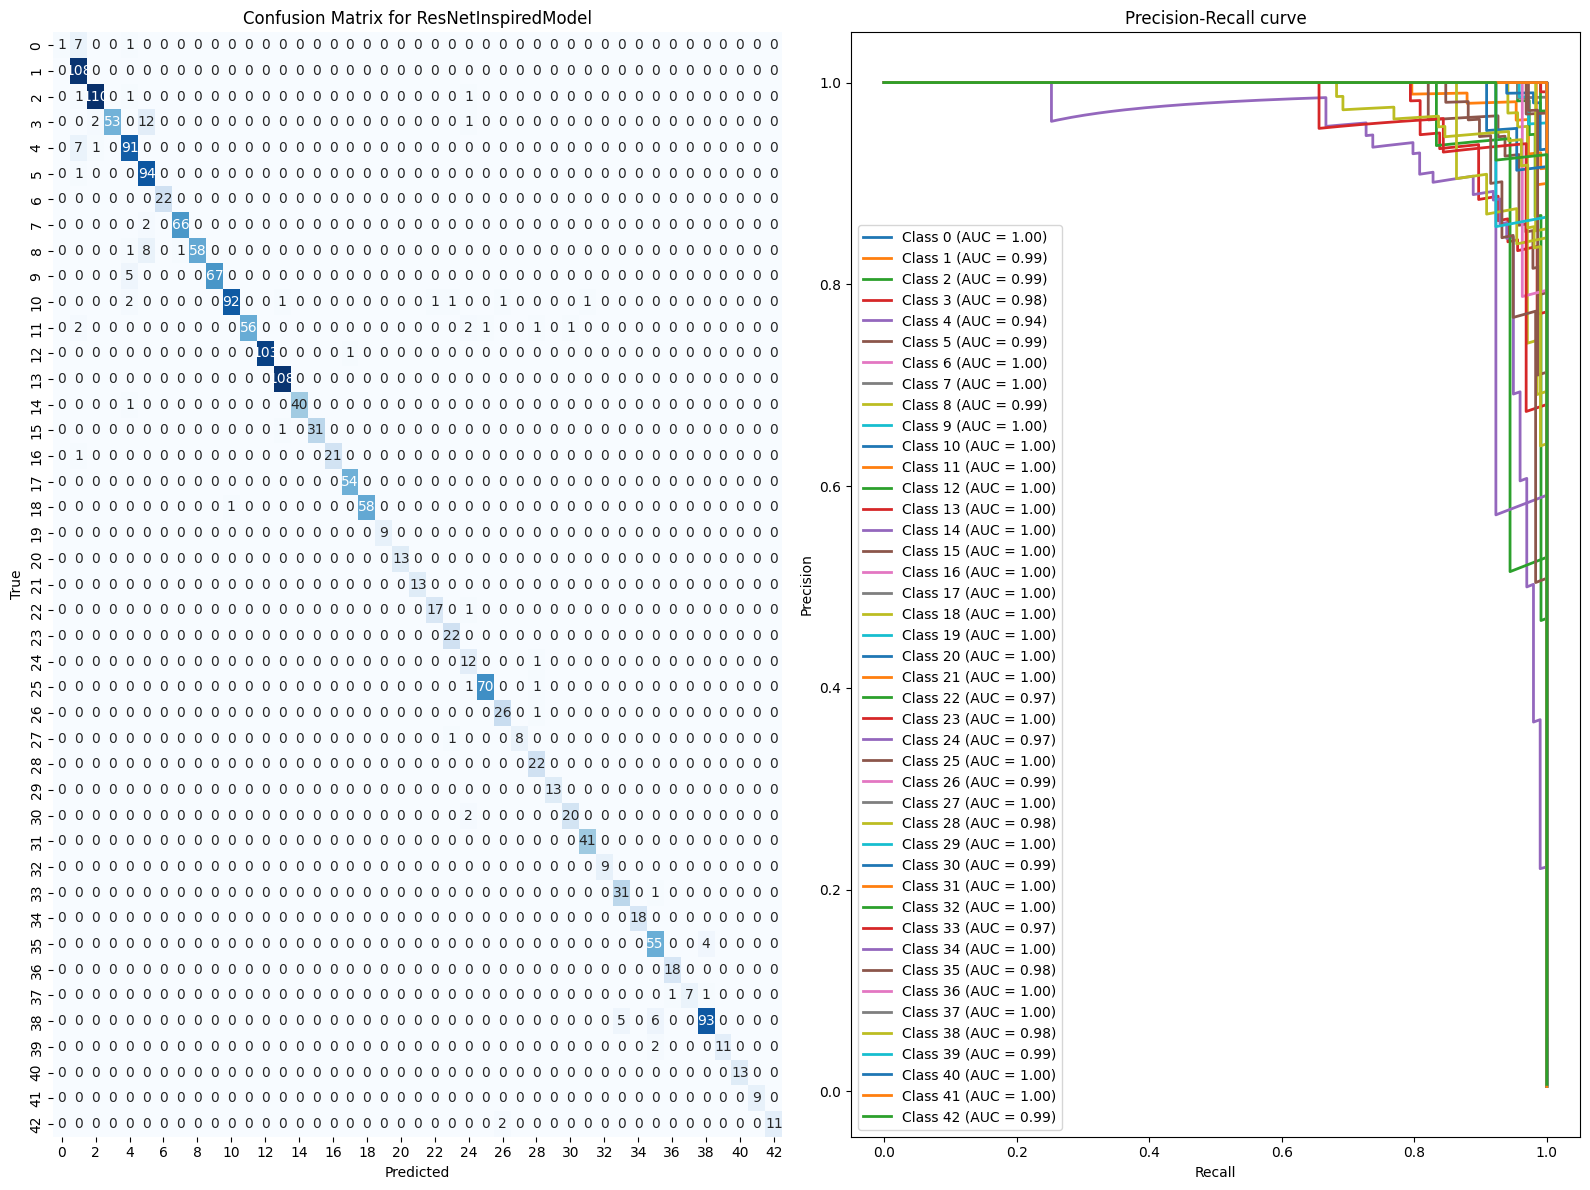

In [20]:
if models_to_run["resnet"]:
    earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5,  restore_best_weights=False)
    plot_losses = TrainingPlot() 
    model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                     epochs=100, batch_size=64, callbacks=[plot_losses, earlystop])
    reports["resnet"] = model.evaluate_model(X_test, y_test)

Conclusion : le modèle atteint une précision de 95% sur les données de test, avec un AUC-ROC proche de 0.9999. Ces résultats montrent que, bien que le modèle inspiré de ResNet performe bien, il est légèrement moins performant que le modèle régularisé en termes de précision générale.

### Comparaison des architectures 
Vue d'ensemble des performances

In [21]:
for model_name, report in reports.items():
    print(f"--- Performance report for {model_name} ---")
    print(report)

--- Performance report for simple ---
                   precision    recall  f1-score      support
accuracy            0.940000  0.940000  0.940000     0.940000
macro avg           0.948000  0.934000  0.939000  1895.000000
weighted avg        0.942000  0.940000  0.940000  1895.000000
AUC-ROC             0.998819  0.998819  0.998819     0.998819
Average Precision   0.975021  0.975021  0.975021     0.975021
--- Performance report for regularized ---
                   precision    recall  f1-score      support
accuracy            0.986000  0.986000  0.986000     0.986000
macro avg           0.990000  0.988000  0.989000  1895.000000
weighted avg        0.987000  0.986000  0.986000  1895.000000
AUC-ROC             0.999954  0.999954  0.999954     0.999954
Average Precision   0.998764  0.998764  0.998764     0.998764
--- Performance report for transfer ---
                   precision    recall  f1-score      support
accuracy            0.842000  0.842000  0.842000     0.842000
macro avg  

#### Synthèse des performances

| Modèle                  | Précision | Rappel  | F1-score | AUC-ROC  | Précision Moyenne (AP) |
|-------------------------|-----------|---------|----------|----------|------------------------|
| Simple CNN              | 93.4%     | 94.0%   | 93.9%    | 0.9988   | 0.9750                 |
| Modèle Régularisé        | **98.6%** | **98.6%**| **98.6%**| **0.9999**| **0.9987**             |
| Modèle Transfer Learning | 84.2%     | 84.2%   | 84.2%    | 0.9941   | 0.9036                 |
| Modèle ResNet-Inspired   | 94.7%     | 94.7%   | 94.6%    | 0.9996   | 0.9930                 |

---

1. **Modèle Simple CNN** : Bien qu'il atteigne une précision raisonnable, le modèle est limité par son architecture peu profonde. Les performances restent inférieures à celles des modèles plus sophistiqués.
   
2. **Modèle Régularisé** : Ce modèle offre les meilleures performances globales, prouvant que des techniques simples comme la régularisation peuvent surpasser les architectures plus complexes si elles sont bien appliquées.

3. **Modèle Transfer Learning** : Le modèle pré-entraîné a sous-performé. Cela pourrait être dû à une inadéquation entre l'architecture obtenue et celles des ensembles de données sur lesquels le modèle a été pré-entraîné.

4. **Modèle Inspiré de ResNet** : Les blocs résiduels aident à stabiliser l'entraînement, mais ne suffisent pas pour battre le modèle régularisé dans ce contexte particulier.

L'approche **régularisée** s'est avérée la plus efficace pour la tâche de classification des panneaux de signalisation. Bien que les modèles plus complexes, comme celui inspiré de **ResNet**, aient montré des mérites, l'ajout de techniques de **régularisation** a permis de surpasser les autres architectures avec de bons résultats. Cela met en évidence que la simplicité associée à des méthodes robustes comme la régularisation peut conduire à des résultats meilleurs.

Des tests supplémentaires, notamment via **l'optimisation des hyperparamètres**, permettront de confirmer ces résultats.

In [22]:
gc.collect()

131841

## 6. **Améliorations et Expérimentations**
L'un des axes principaux d'amélioration consiste à optimiser les hyperparamètres :

* Taux d'apprentissage (learning rate)
* Nombre de filtres
* Nombre de blocs résiduels
* Taux de régularisation (L2 ou Dropout)
* Taille des batchs
* Nombre d'epochs

### 6.1 Optimisation du ResNet Inspired avec ou sans Optuna
#### 6.1.1 `ResNet Inspired` - définition du modèle et des hyperparamètres
Le code initialise les hyperparamètres optimaux pour un modèle ResNet (tels que le taux d'apprentissage et le nombre de blocs résiduels) et les sauvegarde dans un fichier JSON. Cela permet de conserver une trace des meilleurs paramètres obtenus via des expériences précédentes.

In [23]:
# Best params
best_trial = {
    'learning_rate': 0.00018836641433681798,
    'batch_size': 16,
    'filters': 128,
    'kernel_size': 3,
    'residual_blocks': 4,
}
params_dir = '/kaggle/working/params'
os.makedirs(params_dir, exist_ok=True)

with open(os.path.join(params_dir, 'best_resnet_params.json'), 'w') as f:
    json.dump(best_trial, f, indent=4)

print(f"Meilleurs paramètres enregistrés dans {os.path.join(params_dir, 'best_resnet_params.json')}")

Meilleurs paramètres enregistrés dans /kaggle/working/params/best_resnet_params.json


In [24]:
def build_resnet_model(input_shape, num_classes, filters, kernel_size, residual_blocks):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(filters, (7, 7), strides=(2, 2), padding='same', kernel_initializer=HeNormal())(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    
    for _ in range(residual_blocks):
        shortcut = x
        x = Conv2D(filters, kernel_size, padding='same', kernel_initializer=HeNormal())(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel_size, padding='same', kernel_initializer=HeNormal())(x)
        x = BatchNormalization()(x)
        
        if shortcut.shape[-1] != filters:
            shortcut = Conv2D(filters, (1, 1), padding='same', kernel_initializer=HeNormal())(shortcut)
        
        x = Add()([x, shortcut])
        x = ReLU()(x)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax', kernel_initializer=HeNormal())(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

#### 6.1.2 `ResNet Inspired` - otimisation des hyperparamètres avec Optuna (si optimisation=True)
Ici, Optuna est utilisé pour explorer différents jeux d'hyperparamètres de manière automatique afin de minimiser la fonction de perte sur les données de validation. Le modèle ResNet est construit et testé en fonction des hyperparamètres suggérés à chaque itération par Optuna.

In [25]:
def objective_resnet(trial):
    # Hyperparamètres Optuna
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    filters = trial.suggest_categorical('filters', [32, 64, 128])
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
    residual_blocks = trial.suggest_int('residual_blocks', 2, 4)

    # Build
    model = build_resnet_model(input_shape=(64, 64, 3), num_classes=43,
                               filters=filters, kernel_size=kernel_size, residual_blocks=residual_blocks)
    # Compile
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Train
    earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    pruning_callback = TFKerasPruningCallback(trial, 'val_loss')

    history = model.fit(X_train_sample, y_train_sample,
                        validation_data=(X_val_sample, y_val_sample),
                        epochs=50, batch_size=batch_size,
                        callbacks=[earlystop, pruning_callback], verbose=0)

    score = model.evaluate(X_val_sample, y_val_sample, verbose=0)
    return score[0]  # val_loss

#### 6.1.3 `ResNet Inspired` - optimisation et sauvegarde des hyperparamètres trouvés
Si l'optimisation est activée, Optuna effectue plusieurs essais et sauvegarde les meilleurs hyperparamètres trouvés. Sinon, les hyperparamètres préalablement optimisés sont chargés depuis un fichier.

In [26]:
optimisation = False

if optimisation:
    study = optuna.create_study(direction='minimize', study_name='ResNetOptimization')
    study.optimize(objective_resnet, n_trials=100)

    best_params = study.best_params
    params_dir = '/kaggle/working/params/'
    os.makedirs(params_dir, exist_ok=True)

    with open(os.path.join(params_dir, 'best_resnet_params.json'), 'w') as f:
        json.dump(best_params, f)
else:
    with open('/kaggle/working/params/best_resnet_params.json', 'r') as f:
        best_params = json.load(f)

#### 6.1.4 `ResNet Inspired` - compilation du modèle final avec les meilleurs hyperparamètres
Le modèle ResNet final est construit en utilisant les meilleurs hyperparamètres déterminés par l'optimisation. Le modèle est compilé avec un optimiseur Adam et une categorical_crossentropy.

In [27]:
final_resnet_model = build_resnet_model(input_shape=(64, 64, 3), num_classes=43,
                                        filters=best_params['filters'], 
                                        kernel_size=best_params['kernel_size'], 
                                        residual_blocks=best_params['residual_blocks'])

final_resnet_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                           loss='categorical_crossentropy', 
                           metrics=['accuracy'])

final_resnet_model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │     18,944 │ input_layer_5[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ re_lu_5[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │    147,584 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 16,    │    147,584 │ re_lu_6[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 16, 16,    │          0 │ add_2[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16,    │    147,584 │ re_lu_7[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 16,    │    147,584 │ re_lu_8[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_15[0][0] 

 Total params: 1,209,771 (4.61 MB)

 Trainable params: 1,207,467 (4.61 MB)

 Non-trainable params: 2,304 (9.00 KB)

#### 6.1.5 `ResNet Inspired` - entraînement et sauvegarde du modèle
Le modèle final est entraîné sur l'ensemble de données, avec des callbacks pour le suivi des performances et la régularisation (EarlyStopping).

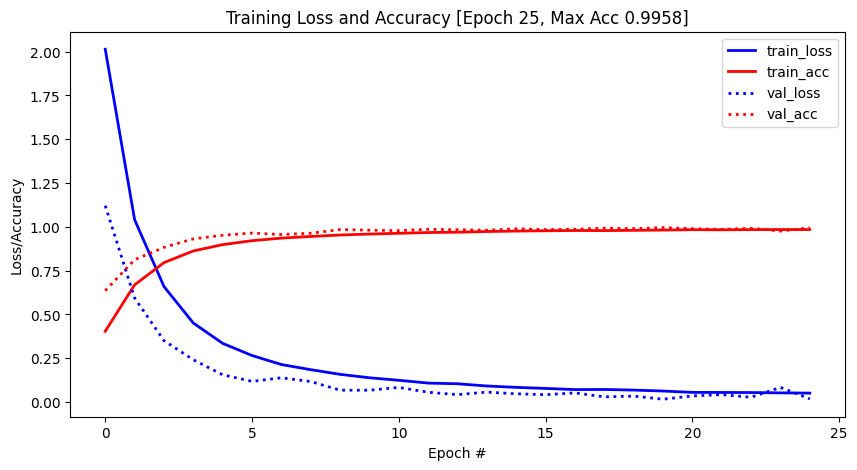

2763/2763 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.9838 - loss: 0.0530 - val_accuracy: 0.9947 - val_loss: 0.0181

Test loss: 0.02321275882422924
Test accuracy: 0.9936675429344177
Modèle sauvegardé sous : /kaggle/working/models/FinalOptimizedResNetModel.h5


In [28]:
def save_model_with_increment(model, base_name="model", save_dir="/kaggle/working/models/"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, base_name)
    index = 1
    new_model_path = f"{model_path}.h5"
    while os.path.exists(new_model_path):
        new_model_path = f"{model_path}_{index}.h5"
        index += 1
    model.save(new_model_path)
    print(f"Modèle sauvegardé sous : {new_model_path}")

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, save_name="FinalOptimizedResNetModel"):
    earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    plot_losses = TrainingPlot()  
    
    # Train
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=epochs, batch_size=batch_size, 
                        callbacks=[plot_losses, earlystop])

    # Évaluation
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest loss: {score[0]}\nTest accuracy: {score[1]}")

    # Sauvegarde
    save_model_with_increment(model, base_name=save_name)
    
# 1. 1st train
train_model(final_resnet_model, X_train, y_train, X_val, y_val, epochs=100, batch_size=best_params['batch_size'])

Une seconde version du modèle final est entraîné sur l'ensemble de données, mais en réutilisant les poids définis lors du 1er entrainement. L'objectif consiste à affiner l'entrainement du model.

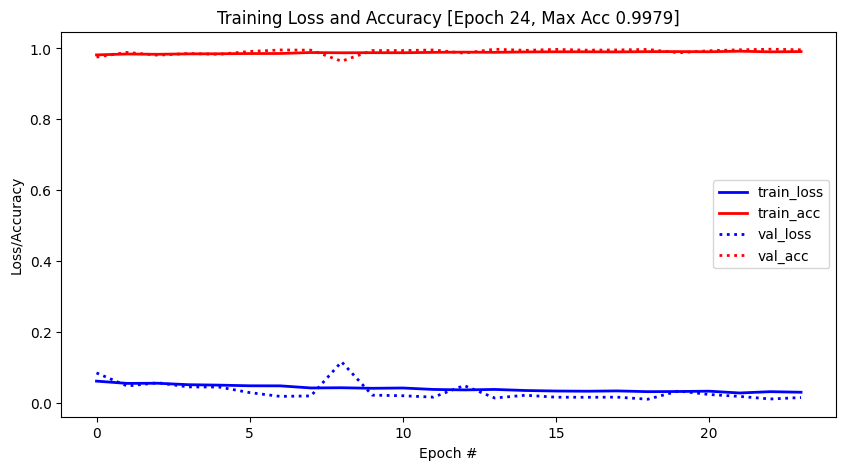

2763/2763 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.9922 - loss: 0.0266 - val_accuracy: 0.9963 - val_loss: 0.0147

Test loss: 0.022974643856287003
Test accuracy: 0.9936675429344177
Modèle sauvegardé sous : /kaggle/working/models/FinalOptimizedResNetModel_1.h5


17101

In [29]:
# 2. 2nd train avec les meilleurs poids
train_model(final_resnet_model, X_train, y_train, X_val, y_val, epochs=100, batch_size=best_params['batch_size'])
gc.collect()

### 6.2 Optimisation du CNN regularized
#### 6.2.1 `CNN regularized` - RandomSearch for CNN regularized with Optuna
De manière similaire à l'optimisation du ResNet, les meilleurs hyperparamètres pour un CNN régularisé (incluant le learning_rate, le batch_size ou encore le taux de dropout) sont sauvegardés dans un fichier JSON pour compilation et entrainement du modèle optimisé. 

In [30]:
# Best params
best_trial = {
    'learning_rate': 0.0007884163834850129,
    'batch_size': 64,
    'dropout_rate1':0.1252963069502372,
    'dropout_rate2':0.18796009627823365 
}
params_dir = '/kaggle/working/params'
os.makedirs(params_dir, exist_ok=True)

with open(os.path.join(params_dir, 'best_regularized_cnn_params.json'), 'w') as f:
    json.dump(best_trial, f, indent=4)

print(f"Meilleurs paramètres enregistrés dans {os.path.join(params_dir, 'best_regularized_cnn_params.json')}")


Meilleurs paramètres enregistrés dans /kaggle/working/params/best_regularized_cnn_params.json


In [31]:
def build_regularized_cnn_model(input_shape, num_classes, dropout_rate1, dropout_rate2):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal()))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal()))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate1))  # Taux de Dropout dynamique

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal()))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=HeNormal()))
    model.add(Dropout(dropout_rate2))  # Taux de Dropout dynamique

    model.add(Dense(64, activation='relu', kernel_initializer=HeNormal()))
    model.add(Dropout(dropout_rate2))

    model.add(Dense(num_classes, activation='softmax'))

    return model

#### 6.2.2 `CNN regularized` - optimisation des hyperparamètres avec Optuna (si optimisation=True)
Optuna est ici utilisé pour optimiser des hyperparamètres spécifiques au CNN régularisé, tels que les taux de dropout et le taux d'apprentissage.

In [32]:
def objective_regularized_cnn(trial, input_shape, num_classes):
    # Hyperparamètres Optuna
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    dropout_rate1 = trial.suggest_float('dropout_rate1', 0.1, 0.5)
    dropout_rate2 = trial.suggest_float('dropout_rate2', 0.1, 0.5)

    # Build
    model = build_regularized_cnn_model(input_shape=input_shape, num_classes=num_classes,
                                         dropout_rate1=dropout_rate1, dropout_rate2=dropout_rate2)
    # Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Train 
    earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    pruning_callback = TFKerasPruningCallback(trial, 'val_loss')

    history = model.fit(X_train_sample, y_train_sample,
                        validation_data=(X_val_sample, y_val_sample),
                        epochs=50, batch_size=batch_size,
                        callbacks=[earlystop, pruning_callback], verbose=0)
    # Evaluate
    score = model.evaluate(X_val_sample, y_val_sample, verbose=0)
    return score[0] # val_loss

#### 6.2.3 `CNN regularized` - optimisation et sauvegarde des meilleurs hyperparamètres identifiés
Si l'optimisation est activée, les meilleurs paramètres sont trouvés et sauvegardés. Sinon, les hyperparamètres déjà optimisés sont chargés à partir d'un fichier.

In [33]:
optimisation = False

if optimisation:
    input_shape=(64, 64, 3)
    num_classes=43
    study = optuna.create_study(direction='minimize', study_name='RegularizedCNNOptimization')
    study.optimize(lambda trial: objective_regularized_cnn(trial, input_shape, num_classes), n_trials=100)

    best_params = study.best_params
    params_dir = '/kaggle/working/params/'
    os.makedirs(params_dir, exist_ok=True)

    with open(os.path.join(params_dir, 'best_regularized_cnn_params.json'), 'w') as f:
        json.dump(best_params, f)
    
else:
    input_shape=(64, 64, 3)
    num_classes=43
    with open('/kaggle/working/params/best_regularized_cnn_params.json', 'r') as f:
        best_params = json.load(f)

#### 6.2.4 `CNN regularized` - compilation du modèle final avec les meilleurs hyperparamètres
Le modèle CNN régularisé est construit et compilé à l'aide des hyperparamètres trouvés, avec une attention particulière aux couches de dropout pour améliorer la généralisation du modèle.

In [34]:
final_regularized_cnn_model = build_regularized_cnn_model(input_shape=input_shape, num_classes=num_classes,
                                                           dropout_rate1=best_params['dropout_rate1'], 
                                                           dropout_rate2=best_params['dropout_rate2'])

final_regularized_cnn_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                                     loss='categorical_crossentropy', 
                                     metrics=['accuracy'])

final_regularized_cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 695,147 (2.65 MB)

 Trainable params: 694,699 (2.65 MB)

 Non-trainable params: 448 (1.75 KB)

#### 6.2.5 `CNN regularized` - entraînement et sauvegarde du modèle
Le CNN régularisé est entraîné avec les mêmes callbacks qu'auparavant, incluant l'early stopping

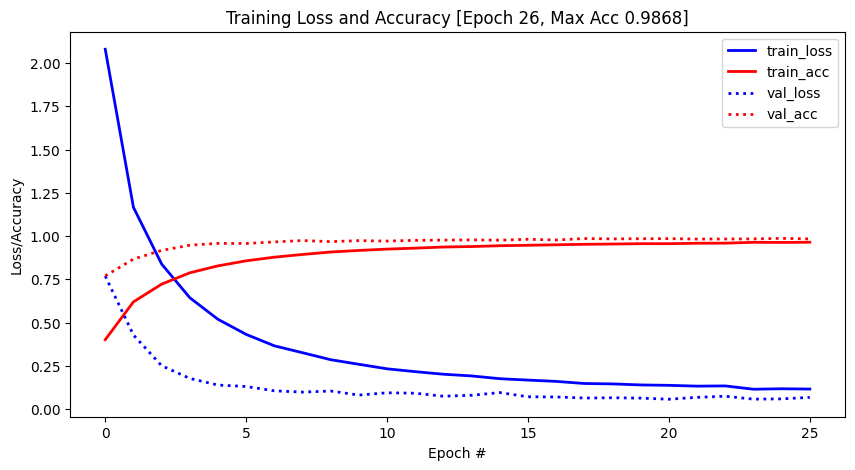

691/691 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9653 - loss: 0.1118 - val_accuracy: 0.9836 - val_loss: 0.0673

Test loss: 0.07254447788000107
Test accuracy: 0.9810026288032532
Modèle sauvegardé sous : /kaggle/working/models/FinalOptimizedRegularizedCNNModel.h5


In [35]:
def save_model_with_increment(model, base_name="model", save_dir="/kaggle/working/models/"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, base_name)
    index = 1
    new_model_path = f"{model_path}.h5"
    while os.path.exists(new_model_path):
        new_model_path = f"{model_path}_{index}.h5"
        index += 1
    model.save(new_model_path)
    print(f"Modèle sauvegardé sous : {new_model_path}")

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, save_name="FinalOptimizedRegularizedCNNModel"):
    earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    plot_losses = TrainingPlot()  
    
    # Train
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=epochs, batch_size=batch_size, 
                        callbacks=[plot_losses, earlystop])

    # Évaluation
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest loss: {score[0]}\nTest accuracy: {score[1]}")

    # Sauvegarde
    save_model_with_increment(model, base_name=save_name)

# 1. 1st Train
train_model(final_regularized_cnn_model, X_train, y_train, X_val, y_val, epochs=100, batch_size=best_params['batch_size'])

Une seconde version du modèle final est entraîné sur l'ensemble de données, mais en réutilisant les poids définis lors du 1er entrainement. L'objectif consiste à affiner l'entrainement du model.

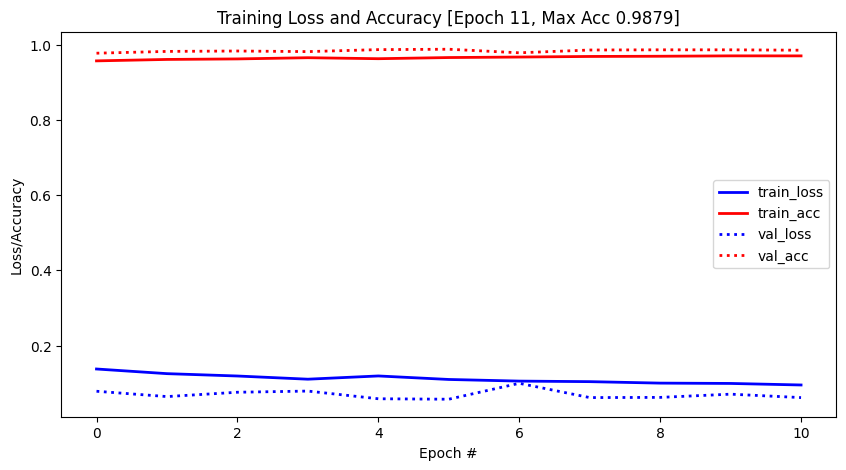

691/691 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9705 - loss: 0.0941 - val_accuracy: 0.9852 - val_loss: 0.0618

Test loss: 0.07293524593114853
Test accuracy: 0.9815303683280945
Modèle sauvegardé sous : /kaggle/working/models/FinalOptimizedRegularizedCNNModel_1.h5


In [36]:
# 2. 2nd Train avec les meilleurs poids
train_model(final_regularized_cnn_model, X_train, y_train, X_val, y_val, epochs=100, batch_size=best_params['batch_size'])

In [37]:
gc.collect()

96922

## 7. **Interprétation et Visualisation des Résultats**
### 7.1 Visualisation de l'activation des couches (CNN + Denses x 2)

In [38]:
resnet_inspired_model = load_model('/kaggle/working/models/FinalOptimizedResNetModel_1.h5')
cnn_regularized_model = load_model('/kaggle/working/models/FinalOptimizedRegularizedCNNModel_1.h5')

### 7.2 Visualisation de l'activation des couches CNN
Les activations des couches convolutives d’un CNN (Convolutional Neural Network) révèlent les caractéristiques spécifiques apprises à chaque étape du processus d’entraînement. 
Visualiser ces activations permet d’analyser quelles parties de l’image déclenchent des réponses dans les différentes couches et comment le réseau comprend les motifs visuels.

Les activations peuvent aussi aider à détecter des problèmes dans la modélisation, comme des filtres non informatifs ou une suradaptation (overfitting) à certaines parties des données.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


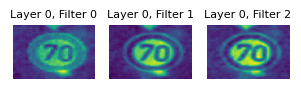

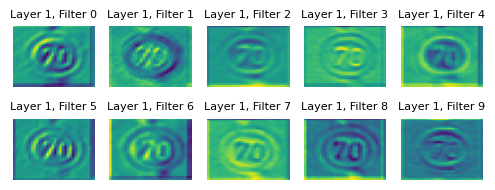

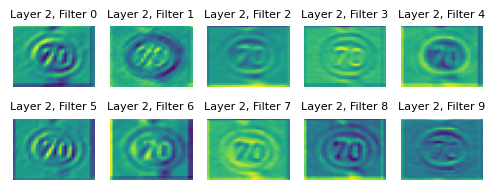

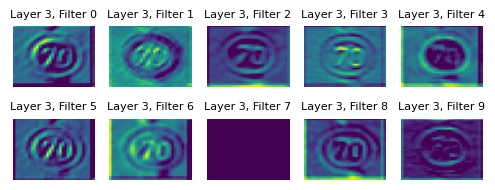

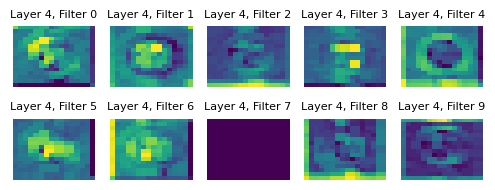

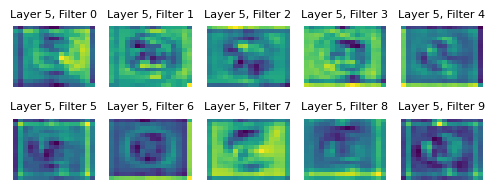

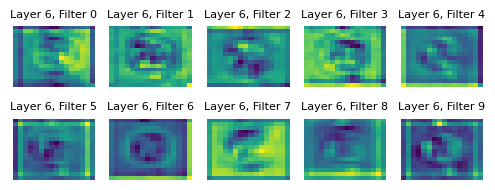

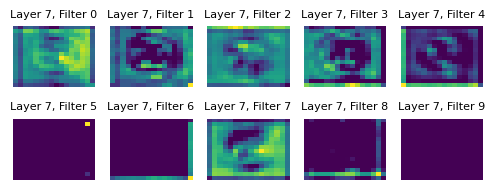

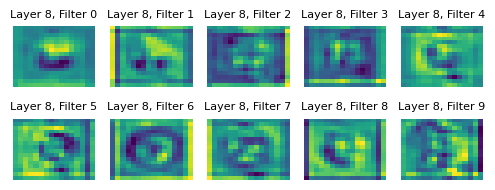

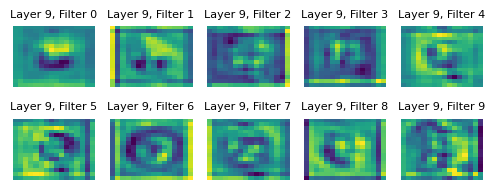

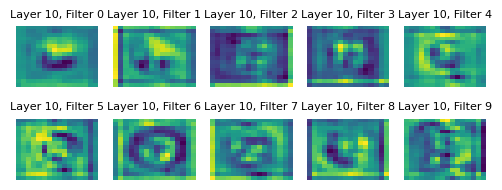

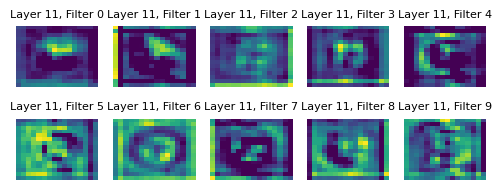

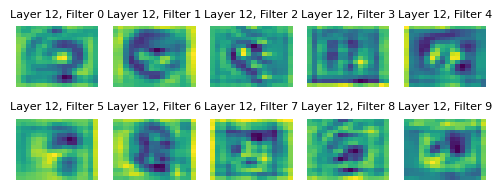

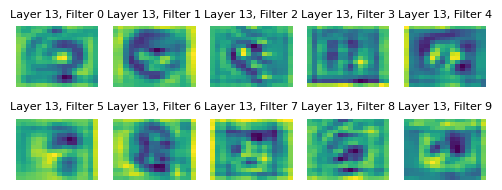

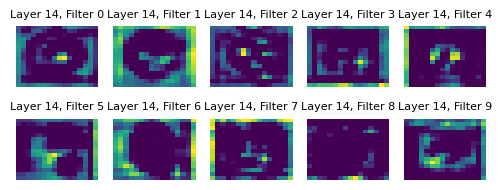

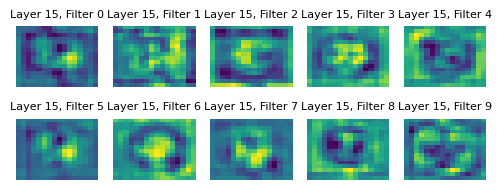

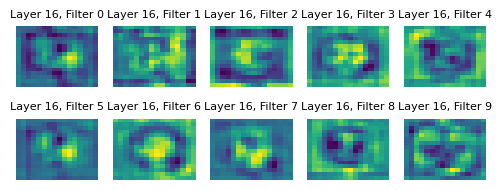

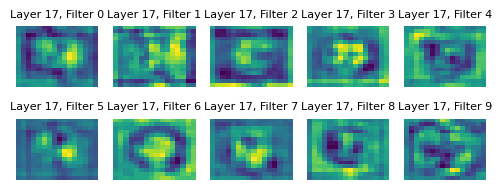

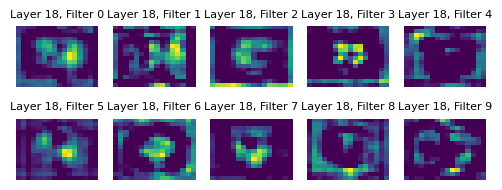

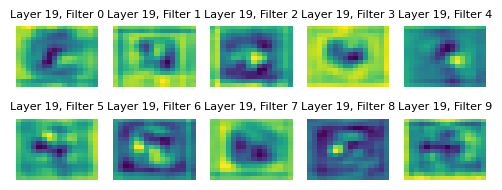

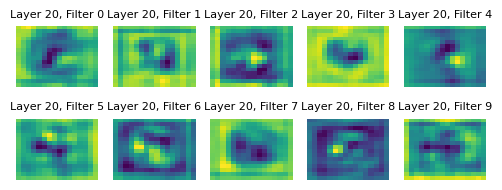

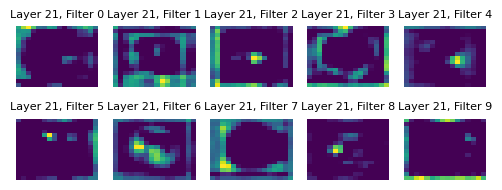

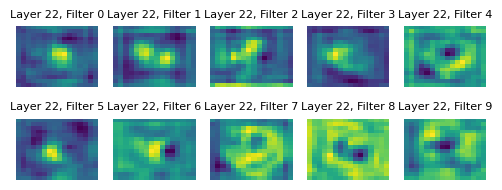

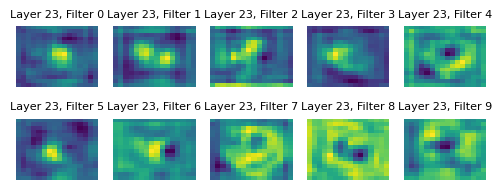

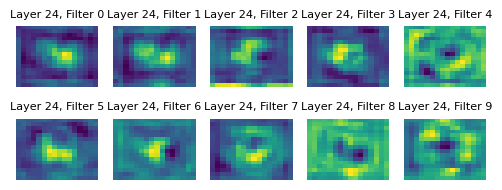

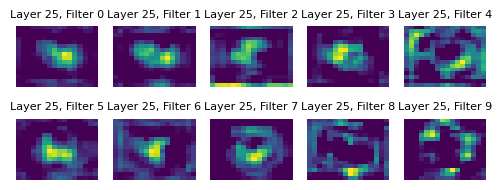

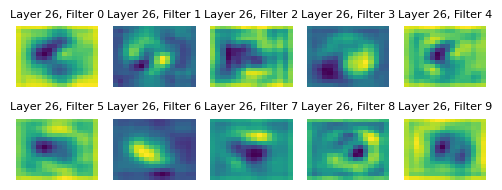

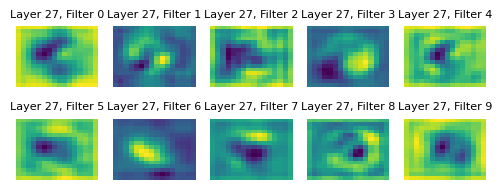

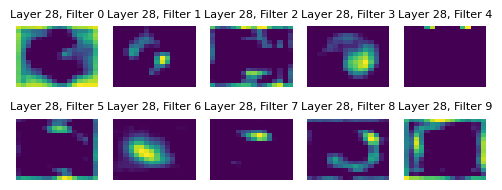

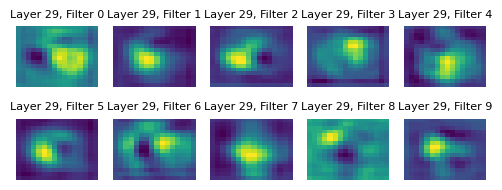

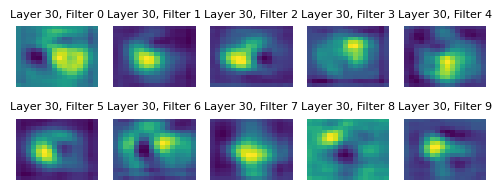

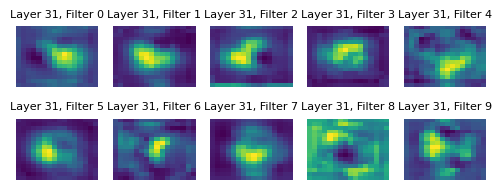

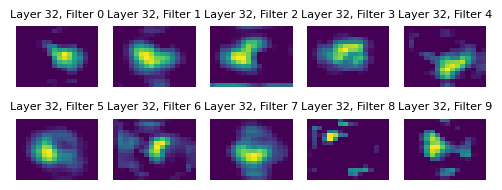

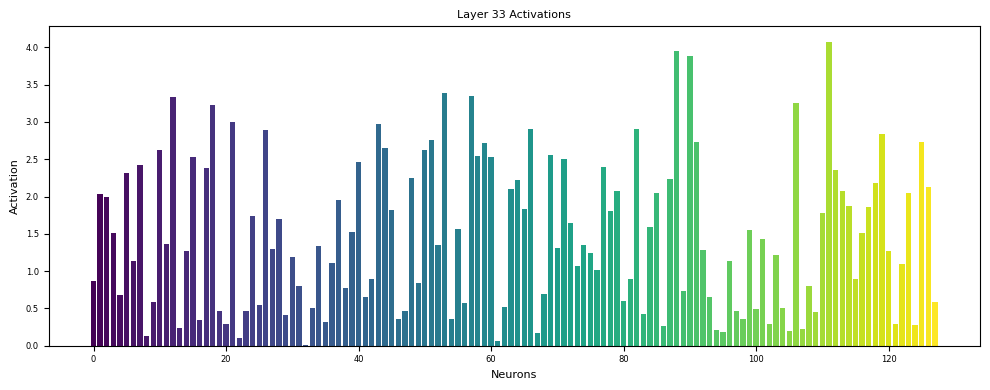

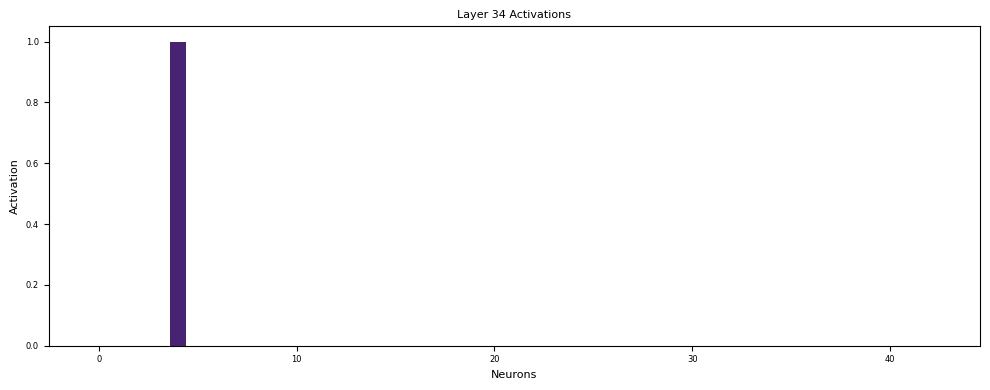

In [39]:
layer_outputs = [layer.output for layer in resnet_inspired_model.layers]  
activation_model = Model(inputs=resnet_inspired_model.input, outputs=layer_outputs)  

img = X_test[0].reshape(1, 64, 64, 3)  

activations = activation_model.predict(img)

for i, activation in enumerate(activations):
    
    if len(activation.shape) == 4:                  # Pour les couches 2D (Conv2D)
        num_filters = activation.shape[3]
        num_filters_to_show = min(num_filters, 10)  # Afficher les 10 premiers filtres
        
        cols = 5  
        rows = (num_filters_to_show + cols - 1) // cols 
        
        plt.figure(figsize=(5, 1 * rows))  
        for j in range(num_filters_to_show):
            plt.subplot(rows, cols, j + 1)  
            plt.imshow(activation[0, :, :, j], cmap=plt.get_cmap('viridis'), aspect='auto')  # filtre
            plt.title(f'Layer {i}, Filter {j}', fontsize=8) 
            plt.axis('off')  
        plt.tight_layout()  
        plt.show()
        
    elif len(activation.shape) == 2:  # Pour les couches denses
        plt.figure(figsize=(10, 4))
        plt.bar(range(activation.shape[1]), activation[0], color=plt.get_cmap('viridis')(np.linspace(0, 1, activation.shape[1]))) 
        plt.title(f'Layer {i} Activations', fontsize=8)  
        plt.xlabel('Neurons', fontsize=8)  
        plt.ylabel('Activation', fontsize=8)  
        plt.xticks(fontsize=6)  
        plt.yticks(fontsize=6) 
        plt.tight_layout()
        plt.show()

### 7.3 Interpretation via Grad-CAM
Permet d'identifier visuellement les parties de l'image qui ont le plus influencé la prédiction du modèle. Cela aide à évaluer si le modèle fait des choix raisonnables ou s'il est biaisé par certaines caractéristiques non pertinentes de l'image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


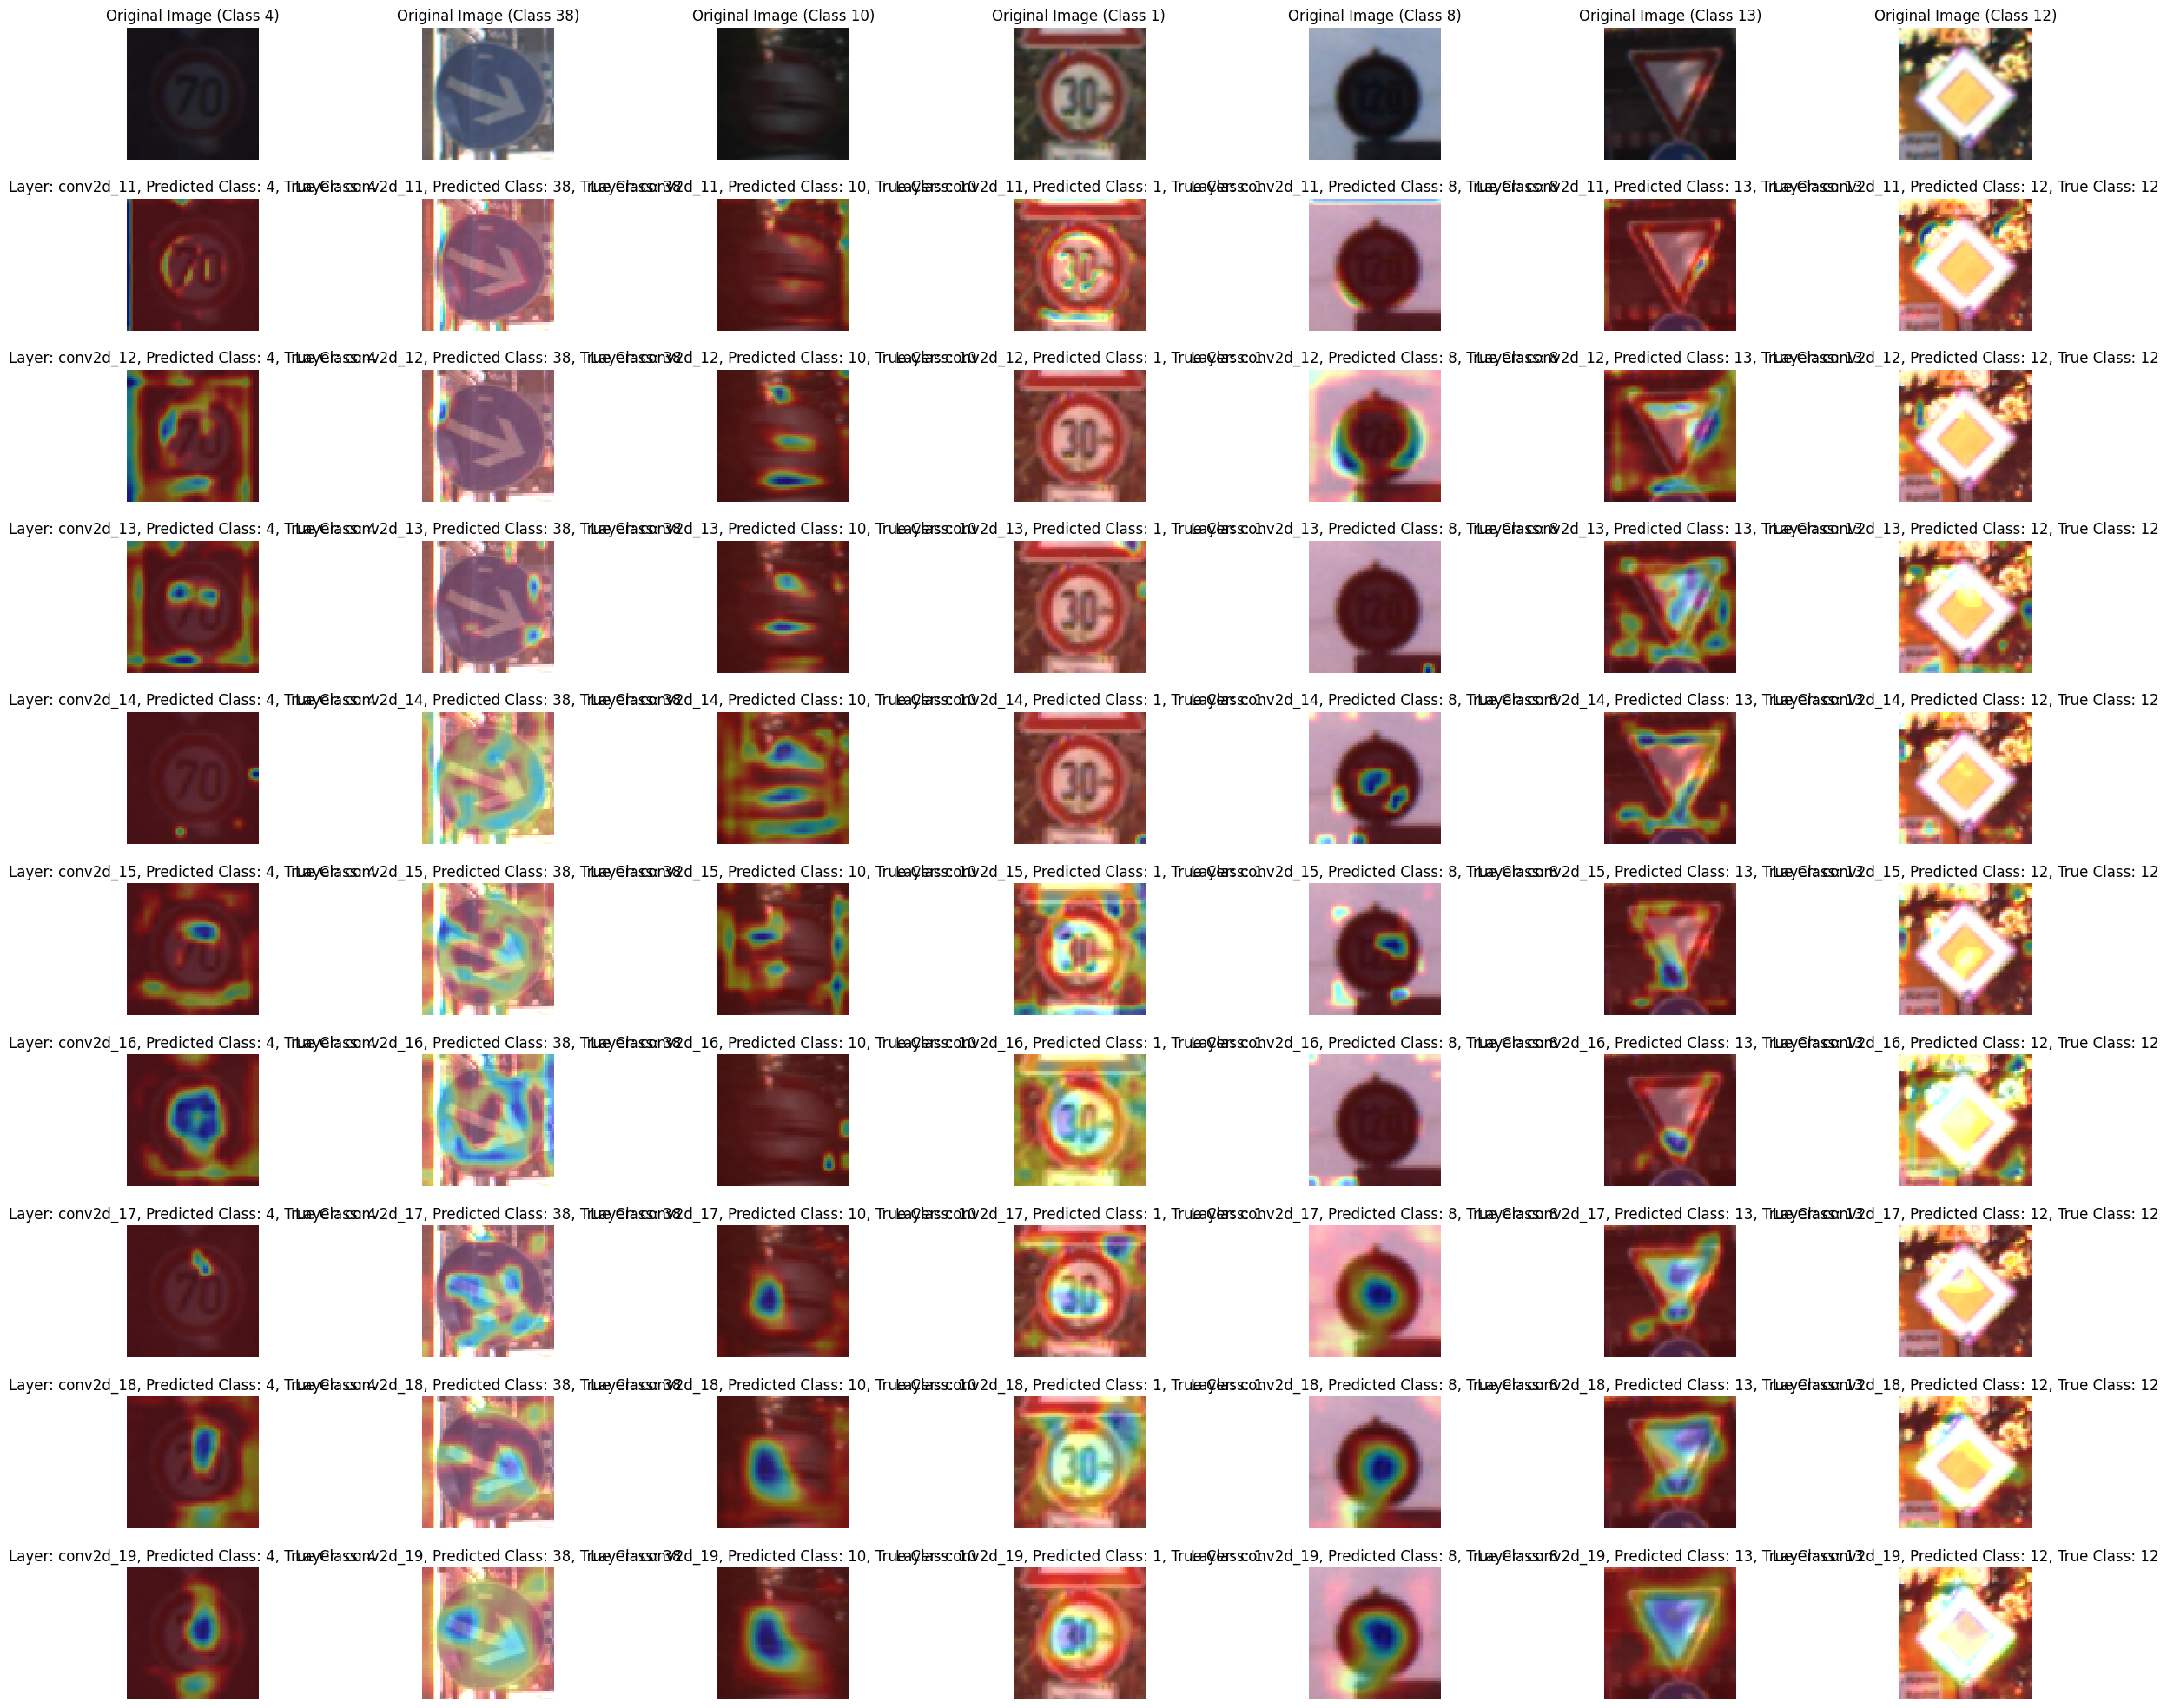

In [40]:
num_images = 7
conv_layers = [layer for layer in resnet_inspired_model.layers if 'conv2d' in layer.name]

unique_classes = np.unique(y_test)  
images_by_class = {}

for img, label in zip(X_test, y_test):  
    class_label = np.argmax(label) if isinstance(label, np.ndarray) else label

    if class_label not in images_by_class and len(images_by_class) < num_images:
        images_by_class[class_label] = img  

selected_images = list(images_by_class.values())
selected_labels = list(images_by_class.keys())

fig, axes = plt.subplots(len(conv_layers) + 1, num_images, figsize=(30, 25))

# Images originales
for i in range(num_images):
    original_image = selected_images[i] 
    ax = axes[0, i] 
    ax.imshow(original_image)
    ax.axis('off')  
    ax.set_title(f'Original Image (Class {selected_labels[i]})', fontsize=12)

# Couches de convolution
for layer_idx, layer in enumerate(conv_layers):
    grad_model = Model(inputs=resnet_inspired_model.input, outputs=[resnet_inspired_model.output,
                                                                   layer.output])
    clear_output(wait=True) 
    
    for i in range(num_images):
        img = selected_images[i].reshape(1, 64, 64, 3)  

        model_predictions = resnet_inspired_model.predict(img)  # Prédire la classe
        class_index = np.argmax(model_predictions) 

        with tf.GradientTape() as tape:
            model_output, conv_output = grad_model(img)       # Sortie et activations
            loss = model_output[0, class_index]  

        grads = tape.gradient(loss, conv_output)              # Calculer le gradient
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Moyenne des gradients

        conv_output = conv_output[0]  
        heatmap = tf.reduce_mean(tf.multiply(conv_output, pooled_grads), axis=-1)  # Calculer la heatmap

        heatmap = tf.maximum(heatmap, 0)  
        if tf.reduce_max(heatmap) > 0:  
            heatmap /= tf.reduce_max(heatmap)   # Normalisation

        heatmap = tf.image.resize(tf.expand_dims(heatmap, axis=-1), (64, 64))  
        heatmap = heatmap.numpy()  
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)  # Appliquer la heatmap

        heatmap = heatmap / 255.0  

        original_image = img[0]                             # Charger l'image d'origine
        superimposed_img = heatmap * 0.4 + original_image   # Superposer la carte de chaleur
        superimposed_img = np.clip(superimposed_img, 0, 1)  # Clipper l'image

        ax = axes[layer_idx + 1, i]  
        ax.imshow(superimposed_img, interpolation='nearest')
        ax.axis('off')  
        ax.set_title(f'Layer: {layer.name}, Predicted Class: {class_index}, True Class: {selected_labels[i]}', fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

### 7.4 Analyse des performances
#### 7.4.1 `ResNet Inspired` - Résultats
Le modèle **ResNet Inspired** a montré d'excellentes performances sur les données de test. Les scores de précision, rappel et f1 sont tous très élevés, avec une précision globale de 99,4%, un rappel de 99,4% et un f1-score également de 99,4%. Ces résultats indiquent que le modèle est capable de faire des prédictions avec une grande exactitude et de minimiser les faux positifs et faux négatifs.

Les métriques globales telles que la **macro moyenne** (qui prend en compte l'équilibre entre les classes) et la **moyenne pondérée** sont également très élevées, autour de 99,6%, ce qui suggère une performance robuste, même dans les cas où les classes pourraient être déséquilibrées. 

De plus, le score **AUC-ROC** de 0,999997 indique que le modèle différencie presque parfaitement entre les classes positives et négatives, et le score **Average Precision** de 0,999859 montre une excellente performance en matière de prédictions positives.

Résumé des métriques :

- **Accuracy** : 99,4%
- **Macro avg** : 99,6%
- **AUC-ROC** : 0,999997
- **Average Precision** : 0,999859

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
--- Performance Metrics for resnet_inspired_model ---


precision    recall  f1-score      support
accuracy            0.994000  0.994000  0.994000     0.994000
macro avg           0.996000  0.995000  0.996000  1895.000000
weighted avg        0.994000  0.994000  0.994000  1895.000000
AUC-ROC             0.999997  0.999997  0.999997     0.999997
Average Precision   0.999859  0.999859  0.999859     0.999859

<Figure size 1600x1200 with 0 Axes>

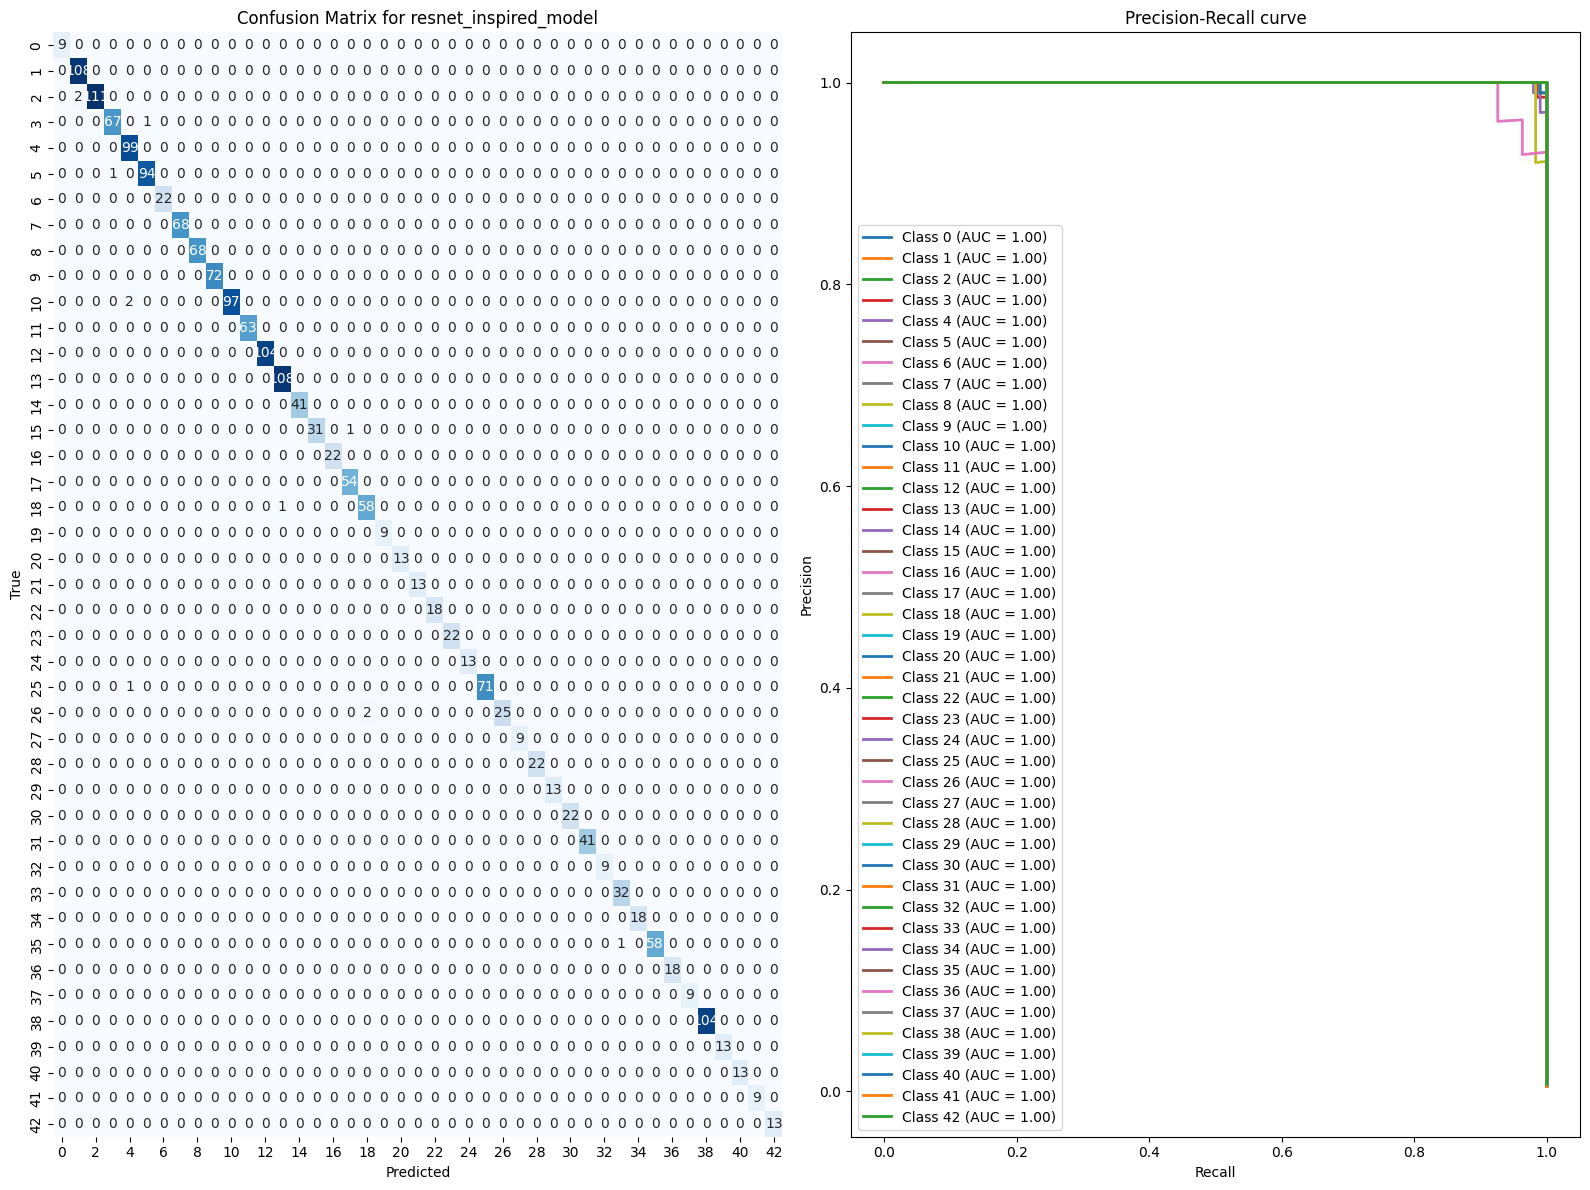

In [41]:
def plot_confusion_matrix(cm, model_name):

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def plot_precision_recall(y_true, y_pred_prob, num_classes):

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true == i, y_pred_prob[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=2, label=f'Class {i} (AUC = {pr_auc:.2f})')

    plt.title('Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_and_pr(cm, y_true, y_pred_prob, model_name, num_classes):
  
    if not isinstance(cm, (np.ndarray, pd.DataFrame)):
        raise ValueError("cm doit être un numpy.ndarray ou un pandas.DataFrame.")
    if len(cm.shape) != 2 or cm.shape[0] != cm.shape[1]:
        raise ValueError("cm doit être une matrice carrée.")

    plt.figure(figsize=(16, 12))
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))

    # Matrice de confusion
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title(f'Confusion Matrix for {model_name}')

    # Courbes de précision-rappel
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true == i, y_pred_prob[:, i])
        pr_auc = auc(recall, precision)
        axes[1].plot(recall, precision, lw=2, label=f'Class {i} (AUC = {pr_auc:.2f})')

    axes[1].set_title('Precision-Recall curve')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

def evaluate_model(model, model_name, X_test, y_test, num_classes):
    print(f"--- Performance Metrics for {model_name} ---")
    
    # Calculer les prédictions du modèle
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.round(3) 

    # Extraire les métriques
    accuracy = report_df.loc['accuracy'].to_frame().T
    macro_avg = report_df.loc[['macro avg']].copy()
    weighted_avg = report_df.loc[['weighted avg']].copy()
    auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
    avg_precision = average_precision_score(y_test, y_pred_prob, average='macro')

    metrics_df = pd.concat([accuracy, macro_avg, weighted_avg], axis=0)
    metrics_df.loc['AUC-ROC'] = auc_roc
    metrics_df.loc['Average Precision'] = avg_precision

    # Générer et afficher la matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix_and_pr(cm, y_true, y_pred_prob, model_name, num_classes)
    
    display(metrics_df)
    return metrics_df

metrics_df = evaluate_model(resnet_inspired_model, 'resnet_inspired_model', X_test, y_test, num_classes=43)

#### 7.4.2 `CNN Regularized` - Résultats
Le modèle **CNN Regularized** présente également de très bonnes performances, mais légèrement inférieures à celles du modèle ResNet Inspired. La précision globale est de 98,2%, tout comme le rappel et le f1-score, ce qui indique une bonne performance, mais avec un peu plus de faux positifs ou de faux négatifs que dans le cas du modèle ResNet Inspired.

Les moyennes macro et pondérée sont autour de 98,5%, suggérant une bonne gestion des classes même si elles sont déséquilibrées. Cependant, ces chiffres sont légèrement inférieurs à ceux du modèle ResNet Inspired, ce qui pourrait indiquer que le modèle CNN Regularized a plus de difficultés à gérer des cas plus complexes.

Le **score AUC-ROC** reste excellent à 0,999928, ce qui montre une capacité solide à discriminer entre les classes. De plus, l'**Average Precision** est également très élevée à 0,998285, ce qui confirme la capacité du modèle à faire des prédictions positives précises.

Résumé des métriques :

- **Accuracy** : 98,2%
- **Macro avg** : 98,5%
- **AUC-ROC** : 0,999928
- **Average Precision** : 0,998285

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
--- Performance Metrics for cnn_regularized_model ---


precision    recall  f1-score      support
accuracy            0.982000  0.982000  0.982000     0.982000
macro avg           0.985000  0.984000  0.984000  1895.000000
weighted avg        0.982000  0.982000  0.982000  1895.000000
AUC-ROC             0.999928  0.999928  0.999928     0.999928
Average Precision   0.998285  0.998285  0.998285     0.998285

<Figure size 1600x1200 with 0 Axes>

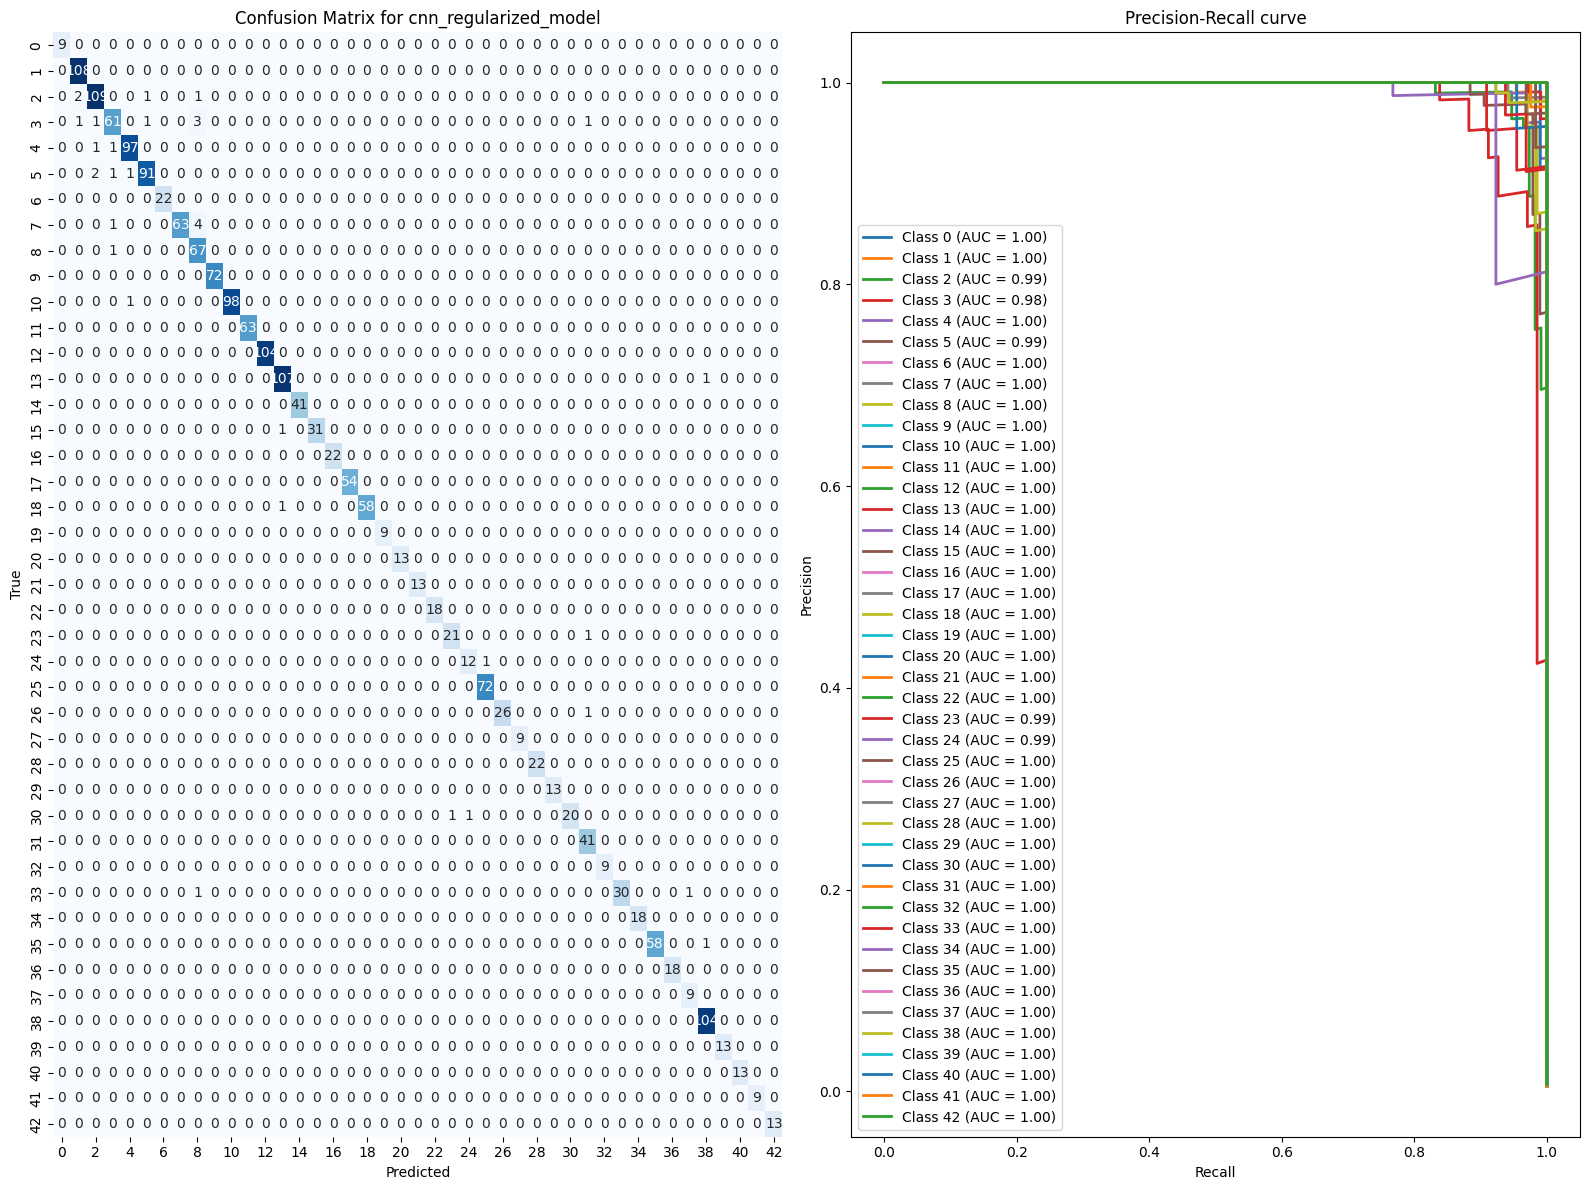

In [42]:
metrics_df = evaluate_model(cnn_regularized_model, 'cnn_regularized_model', X_test, y_test, num_classes=43)

Erreur d'affichage de l'image 4: list index out of range


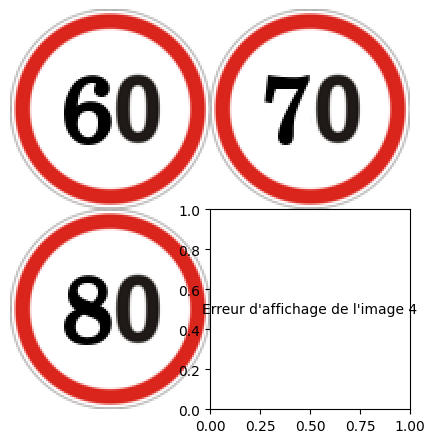

272764

In [43]:
def afficher_images_per_shape(df, num_images=4):

    filtered_df = df[df['ClassId'].isin([3, 4, 5])]
    afficher_images(filtered_df, 'Path', num_images)
    
afficher_images_per_shape(metabase)
gc.collect()

## 8. **Conditions adverses**

Dans cette section, nous allons évaluer la robustesse des modèles développés dans des conditions adverses. Il est crucial de comprendre comment les modèles réagissent face à des scénarios où les données peuvent être corrompues, incomplètes, ou affectées par du bruit, car ces situations reflètent des défis du monde réel. Tester les modèles dans ces conditions permet de juger leur capacité à généraliser et à maintenir une performance acceptable lorsqu'ils sont confrontés à des variations inattendues dans les données d'entrée.  

`Note:` pour des raison de ressources limités, la partie 8 à été réalisée dans un second notebook (see notebook_2_tests-conditions-adverses.ipynb)

# Output
```bash
    .
    ├── architecture
    │   ├── regularized_cnn_architecture.png
    │   ├── regularized_cnn_stylized.png
    │   ├── resnet50_transfer_learning_architecture.png
    │   ├── resnet50_transfer_learning_stylized.png
    │   ├── resnet_inspired_model_architecture.png
    │   ├── resnet_inspired_model_stylized.png
    │   ├── simple_cnn_architecture.png
    │   └── simple_cnn_stylized.png
    ├── models
    │   ├── FinalOptimizedRegularizedCNNModel.h5
    │   ├── FinalOptimizedRegularizedCNNModel_1.h5
    │   ├── FinalOptimizedResNetModel.h5
    │   └── FinalOptimizedResNetModel_1.h5
    └── params
        ├── best_regularized_cnn_params.json
        └── best_resnet_params.json


3 directories, 14 files
```